In [72]:
!pip install ipython
!pip install joblib
!pip install lightgbm
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit_learn
!pip install seaborn
!pip install shap
!pip install xgboost

In [73]:
%matplotlib inline

In [74]:
## Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [75]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [76]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [77]:
## Reading the dataset
# This might be present in S3, or obtained through a query on a database
df = pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/360/Churn_Modelling.csv")

In [78]:
df.head(15).T

0          1          2         3          4   \
RowNumber                1          2          3         4          5   
CustomerId        15634602   15647311   15619304  15701354   15737888   
Surname           Hargrave       Hill       Onio      Boni   Mitchell   
CreditScore            619        608        502       699        850   
Geography           France      Spain     France    France      Spain   
Gender              Female     Female     Female    Female     Female   
Age                     42         41         42        39         43   
Tenure                   2          1          8         1          2   
Balance                0.0   83807.86   159660.8       0.0  125510.82   
NumOfProducts            1          1          3         2          1   
HasCrCard                1          0          1         0          1   
IsActiveMember           1          1          0         0          1   
EstimatedSalary  101348.88  112542.58  113931.57  93826.63    79084.1   
Exited                   1          0          1         0          0   

                        5         6          7          8          9   \
RowNumber                6         7          8          9         10   
CustomerId        15574012  15592531   15656148   15792365   15592389   
Surname                Chu  Bartlett     Obinna         He         H?   
CreditScore            645       822        376        501        684   
Geography            Spain    France    Germany     France     France   
Gender                Male      Male     Female       Male       Male   
Age                     44        50         29         44         27   
Tenure                   8         7          4          4          2   
Balance          113755.78       0.0  115046.74  142051.07  134603.88   
NumOfProducts            2         2          4          2          1   
HasCrCard                1         1          1          0          1   
IsActiveMember           0         1          0          1          1   
EstimatedSalary  149756.71   10062.8  119346.88    74940.5   71725.73   
Exited                   1         0          1          0          0   

                        10        11        12         13        14  
RowNumber               11        12        13         14        15  
CustomerId        15767821  15737173  15632264   15691483  15600882  
Surname             Bearce   Andrews       Kay       Chin     Scott  
CreditScore            528       497       476        549       635  
Geography           France     Spain    France     France     Spain  
Gender                Male      Male    Female     Female    Female  
Age                     31        24        34         25        35  
Tenure                   6         3        10          5         7  
Balance          102016.72       0.0       0.0        0.0       0.0  
NumOfProducts            2         2         2          2         2  
HasCrCard                0         1         1          0         1  
IsActiveMember           0         0         0          0         1  
EstimatedSalary   80181.12  76390.01  26260.98  190857.79  65951.65  
Exited                   0         0         0          0         0

In [79]:
df.describe() # Describe all numerical columns
df.describe(include = ['O']) # Describe all non-numerical/categorical columns

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

Surname Geography Gender
count    10000     10000  10000
unique    2932         3      2
top      Smith    France   Male
freq        32      5014   5457

In [80]:
df_t = df.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

In [81]:
df.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

In [82]:
## Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

## Separating out target variable and removing the non-essential columns
y = df[target_var].values
df.drop(cols_to_remove, axis=1, inplace=True)

In [83]:
## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.1, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state = 42)

df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

<Axes: ylabel='CreditScore'>

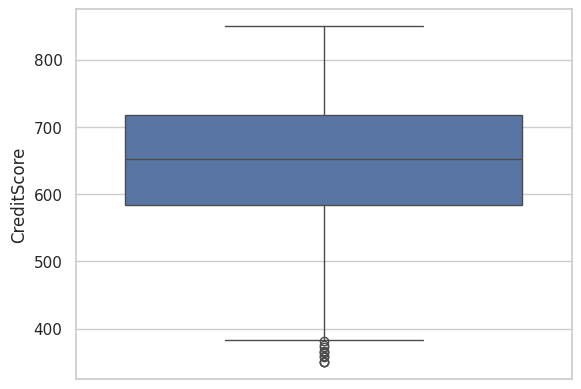

In [84]:
## CreditScore
sns.set(style="whitegrid")
sns.boxplot(y = df_train['CreditScore'])

<Axes: ylabel='Age'>

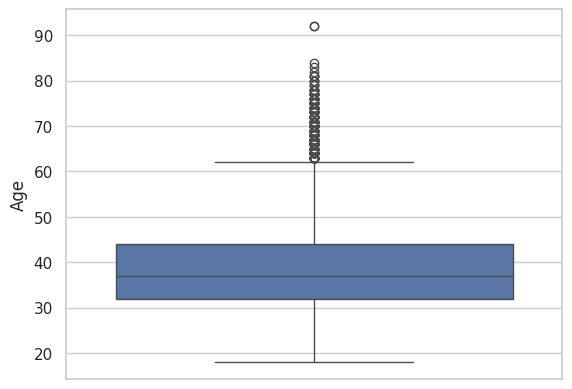

In [85]:
## Age
sns.boxplot(y = df_train['Age'])

<Axes: ylabel='Tenure'>

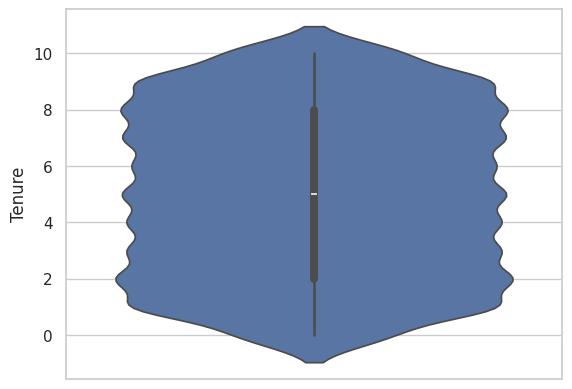

In [86]:
## Tenure
sns.violinplot(y = df_train.Tenure)

<Axes: ylabel='Balance'>

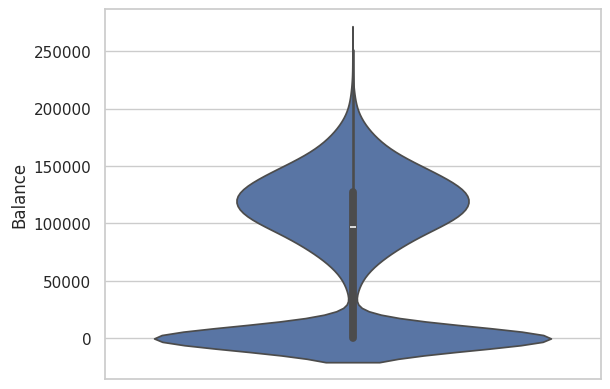

In [87]:
## Balance
sns.violinplot(y = df_train['Balance'])

<ipython-input-88-da8fca0680f0>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.NumOfProducts, hist=True, kde=False)


<Axes: xlabel='NumOfProducts'>

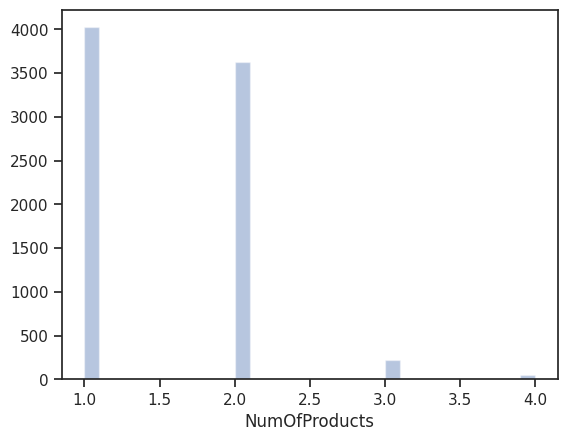

In [88]:
## NumOfProducts
sns.set(style = 'ticks')
sns.distplot(df_train.NumOfProducts, hist=True, kde=False)

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

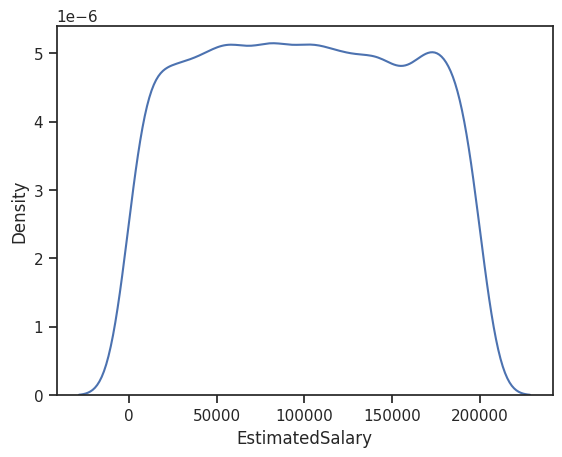

In [89]:
## EstimatedSalary
sns.kdeplot(df_train.EstimatedSalary)

In [90]:
#Missing values
## No missing values!
df_train.isnull().sum()


Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [91]:
## Making all changes in a temporary dataframe
df_missing = df_train.copy()

In [92]:
## Modify few records to add missing values/outliers

# Introducing 10% nulls in Age
na_idx = df_missing.sample(frac = 0.1).index
df_missing.loc[na_idx, 'Age'] = np.NaN

# Introducing 30% nulls in Geography
na_idx = df_missing.sample(frac = 0.3).index
df_missing.loc[na_idx, 'Geography'] = np.NaN

# Introducing 5% nulls in HasCrCard
na_idx = df_missing.sample(frac = 0.05).index
df_missing.loc[na_idx, 'HasCrCard'] = np.NaN

In [93]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.00
CreditScore        0.00
Geography          0.30
Gender             0.00
Age                0.10
Tenure             0.00
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.05
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [94]:
## Calculating mean statistics
age_mean = df_missing.Age.mean()
age_mean

38.93125701459035

In [95]:
## Calculating mean statistics
age_mean = df_train.Age.mean()
age_mean

38.89128787878788

In [96]:
# Filling nulls in Age by mean value (numeric column)

#df_missing.Age.fillna(age_mean, inplace=True)

df_missing['Age'] = df_missing.Age.apply(lambda x: int(np.random.normal(age_mean,3)) if np.isnan(x) else x)

<ipython-input-97-0bc4e506859f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.Age)


<Axes: xlabel='Age', ylabel='Density'>

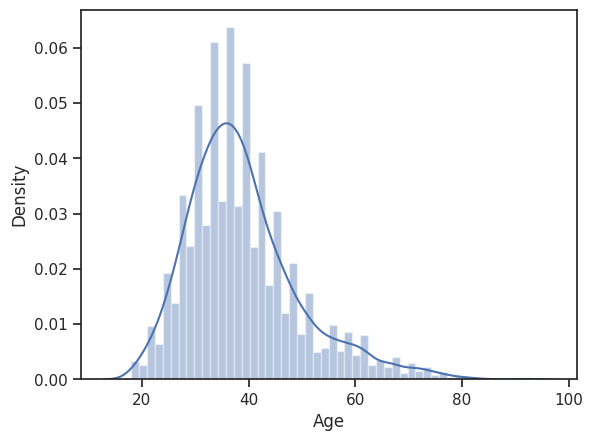

In [97]:
## Distribution of "Age" feature before data imputation
sns.distplot(df_train.Age)

<ipython-input-98-ccb9e4cd04c1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_missing.Age)


<Axes: xlabel='Age', ylabel='Density'>

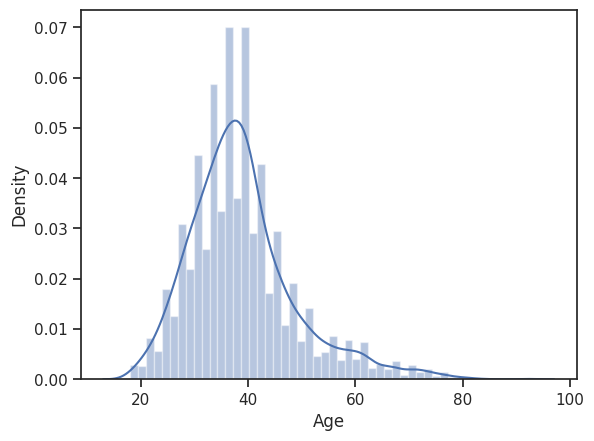

In [98]:
## Distribution of "Age" feature after data imputation
sns.distplot(df_missing.Age)

In [99]:
# Filling nulls in Geography (categorical feature with a high %age of missing values)
geog_fill_value = 'UNK'
df_missing.Geography.fillna(geog_fill_value, inplace=True)

# Filling nulls in HasCrCard (boolean feature) - 0 for few nulls, -1 for lots of nulls
df_missing.HasCrCard.fillna(0, inplace=True)
df_missing.Geography.value_counts(normalize=True)

France     0.351894
UNK        0.300000
Germany    0.174242
Spain      0.173864
Name: Geography, dtype: float64

In [100]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

In [101]:
#Label Encoding for binary variables
## The non-sklearn method

df_train['Gender_cat'] = df_train.Gender.astype('category').cat.codes
df_train.sample(2)

Surname  CreditScore Geography  Gender  Age  Tenure   Balance  \
8584  Cremonesi          731    France    Male   19       6      0.00   
6957     Waters          686    France  Female   44       7  55053.62   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
8584              2          1               1        151581.79       0   
6957              1          1               0        181757.19       0   

      Gender_cat  
8584           1  
6957           0

In [102]:
df_train.drop('Gender_cat', axis=1, inplace = True)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
## Label encoding of Gender variable
df_train['Gender'] = le.fit_transform(df_train['Gender'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

## What if Gender column has new values in test or val set?
le.transform([['Male']])
#le.transform([['ABC']])

pd.Series(['ABC']).map(le_name_mapping)

{'Female': 0, 'Male': 1}

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([1])

0   NaN
dtype: float64

In [103]:
## Encoding Gender feature for validation and test set
df_val['Gender'] = df_val.Gender.map(le_name_mapping)
df_test['Gender'] = df_test.Gender.map(le_name_mapping)

## Filling missing/NaN values created due to new categorical levels
df_val['Gender'].fillna(-1, inplace=True)
df_test['Gender'].fillna(-1, inplace=True)
df_train.Gender.unique(), df_val.Gender.unique(), df_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

In [104]:
## The non-sklearn method
t = pd.get_dummies(df_train, prefix_sep = "_", columns = ['Geography'])
t.head()

Surname  CreditScore  Gender  Age  Tenure    Balance  \
4562      Yermakova          678       1   36       1  117864.85   
6498  Warlow-Davies          613       0   27       5  125167.74   
6072             Fu          628       1   45       9       0.00   
5813           Shih          513       1   30       5       0.00   
7407        Mahmood          639       1   22       4       0.00   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
4562              2          1               0         27619.06       0   
6498              1          1               0        199104.52       0   
6072              2          1               1         96862.56       0   
5813              2          1               0        162523.66       0   
7407              2          1               0         28188.96       0   

      Geography_France  Geography_Germany  Geography_Spain  
4562                 0                  1                0  
6498                 1                  0                0  
6072                 1                  0                0  
5813                 1                  0                0  
7407                 1                  0                0

In [105]:
### Dropping dummy column
t.drop(['Geography_France'], axis=1, inplace=True)
t.head()

Surname  CreditScore  Gender  Age  Tenure    Balance  \
4562      Yermakova          678       1   36       1  117864.85   
6498  Warlow-Davies          613       0   27       5  125167.74   
6072             Fu          628       1   45       9       0.00   
5813           Shih          513       1   30       5       0.00   
7407        Mahmood          639       1   22       4       0.00   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
4562              2          1               0         27619.06       0   
6498              1          1               0        199104.52       0   
6072              2          1               1         96862.56       0   
5813              2          1               0        162523.66       0   
7407              2          1               0         28188.96       0   

      Geography_Germany  Geography_Spain  
4562                  1                0  
6498                  0                0  
6072                  0                0  
5813                  0                0  
7407                  0                0

In [106]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(df_train.Geography).reshape(df_train.shape[0],1)
enc_train.shape
np.unique(enc_train)

(7920, 1)

array([0, 1, 2])

In [107]:
ohe_train = ohe.fit_transform(enc_train)
ohe_train

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [108]:
le_ohe_name_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_name_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [109]:
## Encoding Geography feature for validation and test set
enc_val = df_val.Geography.map(le_ohe_name_mapping).ravel().reshape(-1,1)
enc_test = df_test.Geography.map(le_ohe_name_mapping).ravel().reshape(-1,1)

## Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

np.unique(enc_val)
np.unique(enc_test)

ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

### Show what happens when a new value is inputted into the OHE

ohe.transform(np.array([[9999]]))

array([0, 1, 2])

array([0, 1, 2])

array([[0., 0., 0.]])

In [110]:
#Adding the one-hot encoded columns to the dataframe and removing the original feature
cols = ['country_' + str(x) for x in le_ohe_name_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [111]:
## Adding to the respective dataframes
df_train = pd.concat([df_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
df_val = pd.concat([df_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
df_test = pd.concat([df_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
df_train.head()
print("\n\nValidation set")
df_val.head()
print("\n\nTest set")
df_test.head()
## Drop the Geography column
df_train.drop(['Geography'], axis = 1, inplace=True)
df_val.drop(['Geography'], axis = 1, inplace=True)
df_test.drop(['Geography'], axis = 1, inplace=True)

Training set


Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0      Yermakova          678   Germany       1   36       1  117864.85   
1  Warlow-Davies          613    France       0   27       5  125167.74   
2             Fu          628    France       1   45       9       0.00   
3           Shih          513    France       1   30       5       0.00   
4        Mahmood          639    France       1   22       4       0.00   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              2          1               0         27619.06       0   
1              1          1               0        199104.52       0   
2              2          1               1         96862.56       0   
3              2          1               0        162523.66       0   
4              2          1               0         28188.96       0   

   country_France  country_Germany  country_Spain  
0             0.0              1.0            0.0  
1             1.0              0.0            0.0  
2             1.0              0.0            0.0  
3             1.0              0.0            0.0  
4             1.0              0.0            0.0



Validation set


Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0      Sun          757    France       1   36       7  144852.06   
1    Russo          552    France       1   29      10       0.00   
2    Munro          619    France       0   30       7   70729.17   
3  Perkins          633    France       1   35      10       0.00   
4  Aliyeva          698     Spain       1   38      10   95010.92   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          0               0        130861.95       0   
1              2          1               0         12186.83       0   
2              1          1               1        160948.87       0   
3              2          1               0         65675.47       0   
4              1          1               1        105227.86       0   

   country_France  country_Germany  country_Spain  
0             1.0              0.0            0.0  
1             1.0              0.0            0.0  
2             1.0              0.0            0.0  
3             1.0              0.0            0.0  
4             0.0              0.0            1.0



Test set


Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0  Anderson          596   Germany       1   32       3   96709.07   
1   Herring          623    France       1   43       1       0.00   
2    Amechi          601     Spain       0   44       4       0.00   
3     Liang          506   Germany       1   59       8  119152.10   
4    Chuang          560     Spain       0   27       7  124995.98   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              2          0               0         41788.37       0   
1              2          1               1        146379.30       0   
2              2          1               0         58561.31       0   
3              2          1               1        170679.74       0   
4              1          1               1        114669.79       0   

   country_France  country_Germany  country_Spain  
0             0.0              1.0            0.0  
1             1.0              0.0            0.0  
2             0.0              0.0            1.0  
3             0.0              1.0            0.0  
4             0.0              0.0            1.0

In [112]:
df_train.head(2)

means = df_train.groupby(['Surname']).Exited.mean()
means.head()

global_mean = y_train.mean()
global_mean

Surname  CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  \
0      Yermakova          678       1   36       1  117864.85              2   
1  Warlow-Davies          613       0   27       5  125167.74              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  country_France  \
0          1               0         27619.06       0             0.0   
1          1               0        199104.52       0             1.0   

   country_Germany  country_Spain  
0              1.0            0.0  
1              0.0            0.0

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

0.20303030303030303

In [113]:
## Creating new encoded features for surname - Target (mean) encoding
df_train['Surname_mean_churn'] = df_train.Surname.map(means)
df_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

In [114]:
## Calculate frequency of each category
freqs = df_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [115]:
## Create frequency encoding - Number of instances of each category in the data
df_train['Surname_freq'] = df_train.Surname.map(freqs)
df_train['Surname_freq'].fillna(0, inplace=True)

## Create Leave-one-out target encoding for Surname
df_train['Surname_enc'] = ((df_train.Surname_freq * df_train.Surname_mean_churn) - df_train.Exited)/(df_train.Surname_freq - 1)
df_train.head(3)

Surname  CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  \
0      Yermakova          678       1   36       1  117864.85              2   
1  Warlow-Davies          613       0   27       5  125167.74              1   
2             Fu          628       1   45       9       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  country_France  \
0          1               0         27619.06       0             0.0   
1          1               0        199104.52       0             1.0   
2          1               1         96862.56       0             1.0   

   country_Germany  country_Spain  Surname_mean_churn  Surname_freq  \
0              1.0            0.0                 0.0             4   
1              0.0            0.0                 0.0             2   
2              0.0            0.0                 0.2            10   

   Surname_enc  
0     0.000000  
1     0.000000  
2     0.222222

In [116]:
## Fill NaNs occuring due to category frequency being 1 or less
df_train['Surname_enc'].fillna((((df_train.shape[0] * global_mean) - df_train.Exited) / (df_train.shape[0] - 1)), inplace=True)
df_train.head(3)

Surname  CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  \
0      Yermakova          678       1   36       1  117864.85              2   
1  Warlow-Davies          613       0   27       5  125167.74              1   
2             Fu          628       1   45       9       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  country_France  \
0          1               0         27619.06       0             0.0   
1          1               0        199104.52       0             1.0   
2          1               1         96862.56       0             1.0   

   country_Germany  country_Spain  Surname_mean_churn  Surname_freq  \
0              1.0            0.0                 0.0             4   
1              0.0            0.0                 0.0             2   
2              0.0            0.0                 0.2            10   

   Surname_enc  
0     0.000000  
1     0.000000  
2     0.222222

In [117]:
## Replacing by category means and new category levels by global mean
df_val['Surname_enc'] = df_val.Surname.map(means)
df_val['Surname_enc'].fillna(global_mean, inplace=True)

df_test['Surname_enc'] = df_test.Surname.map(means)
df_test['Surname_enc'].fillna(global_mean, inplace=True)

## Show that using LOO Target encoding decorrelates features
df_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

Surname_mean_churn  Surname_enc    Exited
Surname_mean_churn            1.000000      0.54823  0.562677
Surname_enc                   0.548230      1.00000 -0.026440
Exited                        0.562677     -0.02644  1.000000

In [118]:
### Deleting the 'Surname' and other redundant column across the three datasets
df_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
df_train.drop(['Surname_freq'], axis=1, inplace=True)
df_train.drop(['Surname'], axis=1, inplace=True)
df_val.drop(['Surname'], axis=1, inplace=True)
df_test.drop(['Surname'], axis=1, inplace=True)

df_train.head(2)
df_val.head(2)
df_test.head(2)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          678       1   36       1  117864.85              2          1   
1          613       0   27       5  125167.74              1          1   

   IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
0               0         27619.06       0             0.0              1.0   
1               0        199104.52       0             1.0              0.0   

   country_Spain  Surname_enc  
0            0.0          0.0  
1            0.0          0.0

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          757       1   36       7  144852.06              1          0   
1          552       1   29      10       0.00              2          1   

   IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
0               0        130861.95       0             1.0              0.0   
1               0         12186.83       0             1.0              0.0   

   country_Spain  Surname_enc  
0            0.0     0.111111  
1            0.0     0.200000

CreditScore  Gender  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          596       1   32       3  96709.07              2          0   
1          623       1   43       1      0.00              2          1   

   IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
0               0         41788.37       0             0.0              1.0   
1               1        146379.30       0             1.0              0.0   

   country_Spain  Surname_enc  
0            0.0     0.083333  
1            0.0     0.203030

In [119]:
#Bivariate analysis
## Check linear correlation (rho) between individual features and the target variable
corr = df_train.corr()
corr

CreditScore    Gender       Age    Tenure   Balance  \
CreditScore         1.000000  0.000354  0.002099  0.005994 -0.001507   
Gender              0.000354  1.000000 -0.024446  0.010749  0.009380   
Age                 0.002099 -0.024446  1.000000 -0.011384  0.027721   
Tenure              0.005994  0.010749 -0.011384  1.000000 -0.013081   
Balance            -0.001507  0.009380  0.027721 -0.013081  1.000000   
NumOfProducts       0.014110 -0.026795 -0.033305  0.018231 -0.304318   
HasCrCard          -0.011868  0.007550 -0.019633  0.026148 -0.021464   
IsActiveMember      0.035057  0.028094  0.093573 -0.021263 -0.008085   
EstimatedSalary     0.000358 -0.011007 -0.006827  0.010145  0.027247   
Exited             -0.028117 -0.102331  0.288221 -0.010660  0.113377   
country_France     -0.009481  0.000823 -0.038881  0.000021 -0.231770   
country_Germany     0.003393 -0.018412  0.048764 -0.003131  0.405616   
country_Spain       0.007561  0.017361 -0.003648  0.003090 -0.136044   
Surname_enc        -0.000739  0.008002 -0.010844 -0.006753  0.006925   

                 NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
CreditScore           0.014110  -0.011868        0.035057         0.000358   
Gender               -0.026795   0.007550        0.028094        -0.011007   
Age                  -0.033305  -0.019633        0.093573        -0.006827   
Tenure                0.018231   0.026148       -0.021263         0.010145   
Balance              -0.304318  -0.021464       -0.008085         0.027247   
NumOfProducts         1.000000   0.007202        0.014809         0.009769   
HasCrCard             0.007202   1.000000       -0.006526        -0.008413   
IsActiveMember        0.014809  -0.006526        1.000000        -0.016446   
EstimatedSalary       0.009769  -0.008413       -0.016446         1.000000   
Exited               -0.039200  -0.013659       -0.152477         0.015881   
country_France        0.002991   0.005881        0.002126        -0.004512   
country_Germany      -0.015926   0.008197       -0.020570         0.010583   
country_Spain         0.012388  -0.014934        0.018003        -0.005320   
Surname_enc          -0.002020  -0.000551        0.004902        -0.009899   

                   Exited  country_France  country_Germany  country_Spain  \
CreditScore     -0.028117       -0.009481         0.003393       0.007561   
Gender          -0.102331        0.000823        -0.018412       0.017361   
Age              0.288221       -0.038881         0.048764      -0.003648   
Tenure          -0.010660        0.000021        -0.003131       0.003090   
Balance          0.113377       -0.231770         0.405616      -0.136044   
NumOfProducts   -0.039200        0.002991        -0.015926       0.012388   
HasCrCard       -0.013659        0.005881         0.008197      -0.014934   
IsActiveMember  -0.152477        0.002126        -0.020570       0.018003   
EstimatedSalary  0.015881       -0.004512         0.010583      -0.005320   
Exited           1.000000       -0.106006         0.173492      -0.050264   
country_France  -0.106006        1.000000        -0.575048      -0.581494   
country_Germany  0.173492       -0.575048         1.000000      -0.331194   
country_Spain   -0.050264       -0.581494        -0.331194       1.000000   
Surname_enc     -0.026440       -0.007467        -0.006132       0.014710   

                 Surname_enc  
CreditScore        -0.000739  
Gender              0.008002  
Age                -0.010844  
Tenure             -0.006753  
Balance             0.006925  
NumOfProducts      -0.002020  
HasCrCard          -0.000551  
IsActiveMember      0.004902  
EstimatedSalary    -0.009899  
Exited             -0.026440  
country_France     -0.007467  
country_Germany    -0.006132  
country_Spain       0.014710  
Surname_enc         1.000000

<Axes: >

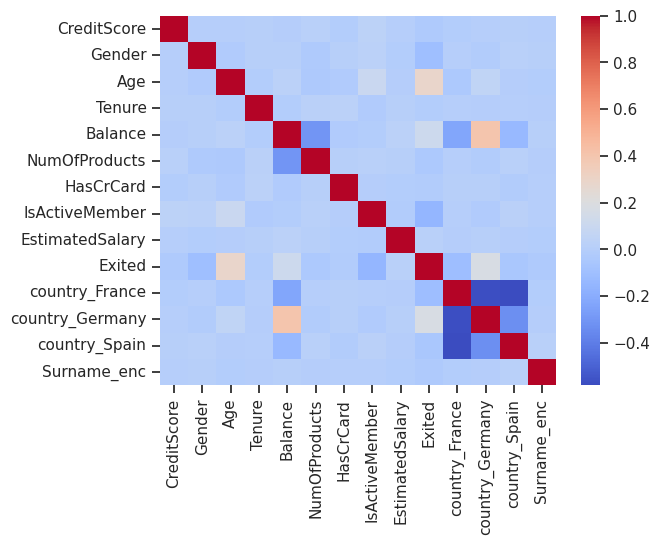

In [120]:
sns.heatmap(corr, cmap = 'coolwarm')

<ipython-input-121-03265e1fb942>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Exited", y = "Age", data = df_train, palette="Set3")


<Axes: xlabel='Exited', ylabel='Age'>

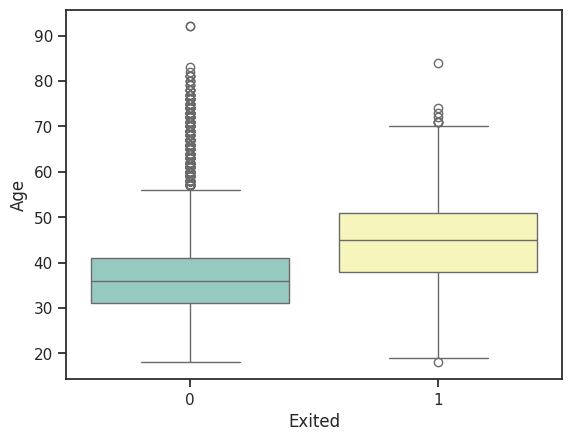

In [121]:
sns.boxplot(x = "Exited", y = "Age", data = df_train, palette="Set3")

<ipython-input-122-125d53d4715c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = "Exited", y = "Balance", data = df_train, palette="Set3")


<Axes: xlabel='Exited', ylabel='Balance'>

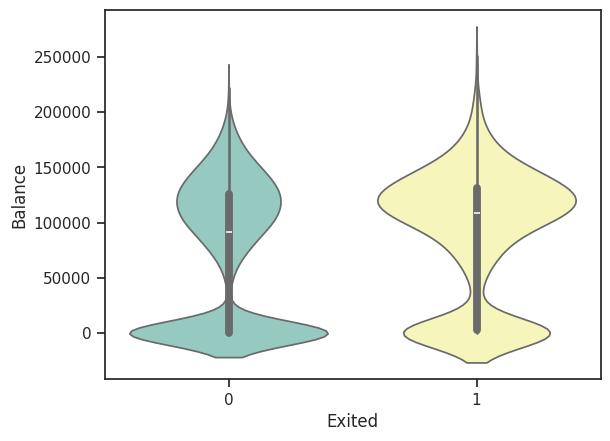

In [122]:
sns.violinplot(x = "Exited", y = "Balance", data = df_train, palette="Set3")

In [123]:
# Check association of categorical features with target variable
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    df_train.groupby([col]).Exited.mean()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

In [124]:
col = 'NumOfProducts'
df_train.groupby([col]).Exited.mean()
df_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

In [125]:
#Some basic feature engineering
df_train.columns

eps = 1e-6

df_train['bal_per_product'] = df_train.Balance/(df_train.NumOfProducts + eps)
df_train['bal_by_est_salary'] = df_train.Balance/(df_train.EstimatedSalary + eps)
df_train['tenure_age_ratio'] = df_train.Tenure/(df_train.Age + eps)
df_train['age_surname_mean_churn'] = np.sqrt(df_train.Age) * df_train.Surname_enc

df_train.head(3)

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc'],
      dtype='object')

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          678       1   36       1  117864.85              2          1   
1          613       0   27       5  125167.74              1          1   
2          628       1   45       9       0.00              2          1   

   IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
0               0         27619.06       0             0.0              1.0   
1               0        199104.52       0             1.0              0.0   
2               1         96862.56       0             1.0              0.0   

   country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
0            0.0     0.000000     58932.395534           4.267519   
1            0.0     0.000000    125167.614832           0.628653   
2            0.0     0.222222         0.000000           0.000000   

   tenure_age_ratio  age_surname_mean_churn  
0          0.027778                0.000000  
1          0.185185                0.000000  
2          0.200000                1.490712

In [126]:
new_cols = ['bal_per_product','bal_by_est_salary','tenure_age_ratio','age_surname_mean_churn']
## Ensuring that the new column doesn't have any missing values
df_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<Axes: >

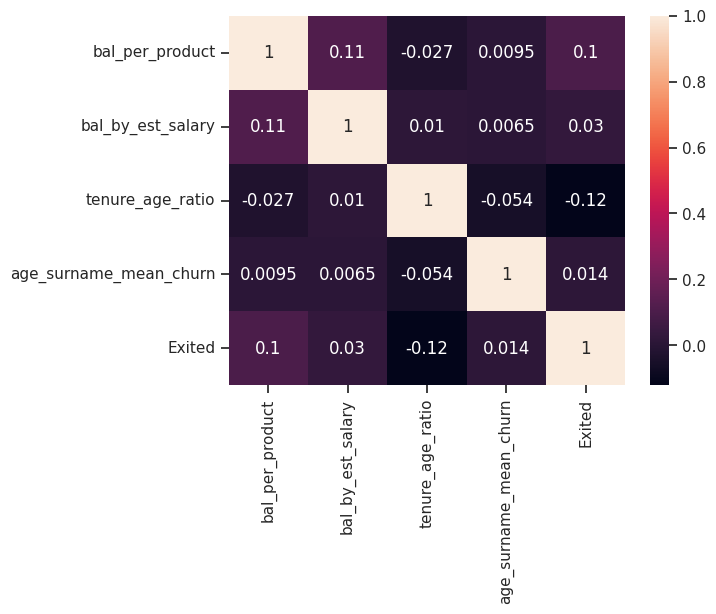

In [127]:
## Linear association of new columns with target variables to judge importance
sns.heatmap(df_train[new_cols + ['Exited']].corr(), annot=True)

In [128]:
## Creating new interaction feature terms for validation set
eps = 1e-6

df_val['bal_per_product'] = df_val.Balance/(df_val.NumOfProducts + eps)
df_val['bal_by_est_salary'] = df_val.Balance/(df_val.EstimatedSalary + eps)
df_val['tenure_age_ratio'] = df_val.Tenure/(df_val.Age + eps)
df_val['age_surname_mean_churn'] = np.sqrt(df_val.Age) * df_val.Surname_enc

In [129]:
## Creating new interaction feature terms for test set
eps = 1e-6

df_test['bal_per_product'] = df_test.Balance/(df_test.NumOfProducts + eps)
df_test['bal_by_est_salary'] = df_test.Balance/(df_test.EstimatedSalary + eps)
df_test['tenure_age_ratio'] = df_test.Tenure/(df_test.Age + eps)
df_test['age_surname_mean_churn'] = np.sqrt(df_test.Age) * df_test.Surname_enc

<ipython-input-130-ecd9b16045ed>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.EstimatedSalary, hist=False)


<Axes: xlabel='EstimatedSalary', ylabel='Density'>

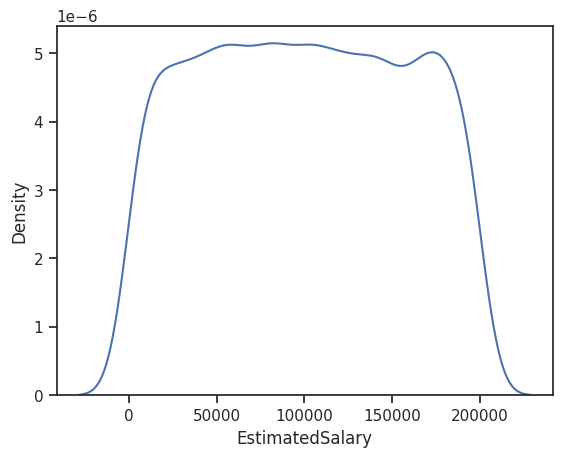

In [130]:
#Feature scaling and normalization
#Feature transformations

### Demo-ing feature transformations
sns.distplot(df_train.EstimatedSalary, hist=False)


<ipython-input-131-4333fc4836e3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.sqrt(df_train.EstimatedSalary), hist=False)


<Axes: xlabel='EstimatedSalary', ylabel='Density'>

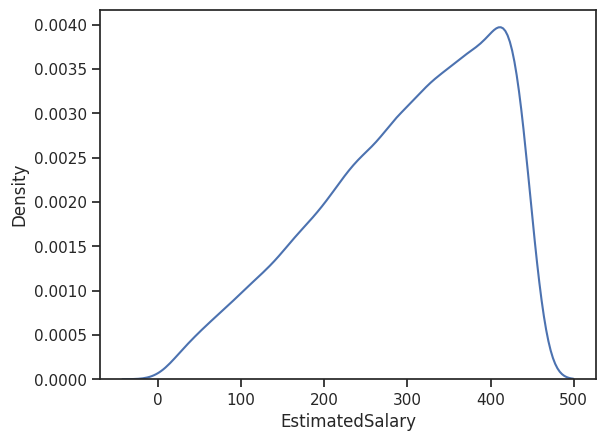

In [131]:
sns.distplot(np.sqrt(df_train.EstimatedSalary), hist=False)
#sns.distplot(np.log10(1+df_train.EstimatedSalary), hist=False)

In [132]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_train.columns

cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']

## Scaling only continuous columns
cols_to_scale = cont_vars

sc_X_train = sc.fit_transform(df_train[cols_to_scale])

## Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data = sc_X_train, columns = cols_to_scale)
sc_X_train.shape
sc_X_train.head()

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

(7920, 11)

CreditScore       Age    Tenure   Balance  NumOfProducts  EstimatedSalary  \
0     0.284761 -0.274383 -1.389130  0.670778       0.804059        -1.254732   
1    -0.389351 -1.128482 -0.004763  0.787860      -0.912423         1.731950   
2    -0.233786  0.579716  1.379604 -1.218873       0.804059        -0.048751   
3    -1.426446 -0.843782 -0.004763 -1.218873       0.804059         1.094838   
4    -0.119706 -1.602981 -0.350855 -1.218873       0.804059        -1.244806   

   Surname_enc  bal_per_product  bal_by_est_salary  tenure_age_ratio  \
0    -1.079210        -0.062389           0.095448         -1.232035   
1    -1.079210         1.104840          -0.118834          0.525547   
2     0.094549        -1.100925          -0.155854          0.690966   
3     0.505364        -1.100925          -0.155854          0.318773   
4     1.561746        -1.100925          -0.155854          0.487952   

   age_surname_mean_churn  
0               -1.062507  
1               -1.062507  
2                0.193191  
3                0.321611  
4                0.912973

In [133]:
## Mapping learnt on the continuous features
sc_map = {'mean':sc.mean_, 'std':np.sqrt(sc.var_)}
sc_map

{'mean': array([6.50542424e+02, 3.88912879e+01, 5.01376263e+00, 7.60258447e+04,
        1.53156566e+00, 9.96616540e+04, 2.04321788e-01, 6.24727199e+04,
        2.64665647e+00, 1.38117689e-01, 1.26136416e+00]),
 'std': array([9.64231806e+01, 1.05374237e+01, 2.88940724e+00, 6.23738902e+04,
        5.82587032e-01, 5.74167173e+04, 1.89325378e-01, 5.67456646e+04,
        1.69816787e+01, 8.95590667e-02, 1.18715858e+00])}

In [134]:
## Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(df_val[cols_to_scale])
sc_X_test = sc.transform(df_test[cols_to_scale])

In [135]:
## Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data = sc_X_val, columns = cols_to_scale)
sc_X_test = pd.DataFrame(data = sc_X_test, columns = cols_to_scale)

In [136]:
#Feature selection - RFE

cont_vars
cat_vars

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain']

In [137]:
## Creating feature-set and target for RFE model
y = df_train['Exited'].values
#X = pd.concat([df_train[cat_vars], sc_X_train[cont_vars]], ignore_index=True, axis = 1)
X = df_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars

In [138]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [139]:
# for logistics regression
est = LogisticRegression()
num_features_to_select = 10

# for decision trees
est_dt = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
num_features_to_select = 10


In [140]:
rfe = RFE(estimator=est, n_features_to_select=num_features_to_select)
rfe = rfe.fit(X.values, y)
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 5 1 4 6 1 8 1 7 3 1 2]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [141]:

# for decision trees
rfe_dt = RFE(estimator=est_dt, n_features_to_select=num_features_to_select)
rfe_dt = rfe_dt.fit(X.values, y)
print(rfe_dt.support_)
print(rfe_dt.ranking_)


[False False  True False  True False False  True False False  True  True
  True  True  True  True  True]
[8 7 1 6 1 5 4 1 3 2 1 1 1 1 1 1 1]


In [142]:
# Create a logistic regression model
est_lr = LogisticRegression()

# Fit the model on the data
est_lr.fit(X, y)

# Get the feature importance scores
importances_lr = est_lr.coef_[0]

# Sort feature importances in descending order
indices_lr = np.argsort(np.abs(importances_lr))[::-1]

# Select the top k features
selected_feats_lr = X.columns[indices_lr][:num_features_to_select]

# Print selected features for Logistic Regression
print("Selected features for Logistic Regression:", selected_feats_lr)

LogisticRegression()

Selected features for Logistic Regression: Index(['Age', 'CreditScore', 'bal_by_est_salary', 'Tenure', 'IsActiveMember',
       'Gender', 'country_Germany', 'country_France', 'NumOfProducts',
       'country_Spain'],
      dtype='object')


In [143]:
## Decision Tree (Non-linear model)
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [144]:
#Baseline models (Non-linear) : Decision Tree

In [145]:
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [146]:
selected_feats = selected_feats_lr  # Assuming you want to use logistic regression features
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

In [147]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [148]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weights
num_samples

array([1.        , 3.92537313])

array([6312, 1608])

In [149]:
weights_dict = dict()
class_labels = [0,1]
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [150]:
## Defining model
lr = LogisticRegression(C = 1.0, penalty = 'l2', class_weight = weights_dict, n_jobs = -1)

In [151]:
## Fitting model
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

In [152]:
## Fitted model parameters
selected_cat_vars + selected_cont_vars

lr.coef_
lr.intercept_

['IsActiveMember',
 'Gender',
 'country_Germany',
 'country_France',
 'country_Spain',
 'Age',
 'CreditScore',
 'bal_by_est_salary',
 'Tenure',
 'NumOfProducts']

array([[-0.90190569, -0.52112909,  0.58433016, -0.33810706, -0.24620838,
         0.82971821, -0.06887208,  0.03437762, -0.02659213, -0.0488976 ]])

array([0.55336147])

In [153]:
## Training metrics
roc_auc_score(y_train, lr.predict(X_train))
recall_score(y_train, lr.predict(X_train))
confusion_matrix(y_train, lr.predict(X_train))
print(classification_report(y_train, lr.predict(X_train)))

0.7066970281671491

0.697139303482587

array([[4521, 1791],
       [ 487, 1121]])

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      6312
           1       0.38      0.70      0.50      1608

    accuracy                           0.71      7920
   macro avg       0.64      0.71      0.65      7920
weighted avg       0.80      0.71      0.74      7920



In [154]:
## Validation metrics
roc_auc_score(y_val, lr.predict(X_val))
recall_score(y_val, lr.predict(X_val))
confusion_matrix(y_val, lr.predict(X_val))
print(classification_report(y_val, lr.predict(X_val)))

0.7044851194634624

0.7058823529411765

array([[592, 250],
       [ 70, 168]])

              precision    recall  f1-score   support

           0       0.89      0.70      0.79       842
           1       0.40      0.71      0.51       238

    accuracy                           0.70      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.79      0.70      0.73      1080



In [155]:
#More linear models - SVM
from sklearn.svm import SVC

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [156]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [157]:
weights_dict = {0: 1.0, 1: 3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [158]:
svm = SVC(C = 1.0, kernel = "linear", class_weight = weights_dict)
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.92}, kernel='linear')

In [159]:
## Fitted model parameters
selected_cat_vars + selected_cont_vars

svm.coef_
svm.intercept_

['IsActiveMember',
 'Gender',
 'country_Germany',
 'country_France',
 'country_Spain',
 'Age',
 'CreditScore',
 'bal_by_est_salary',
 'Tenure',
 'NumOfProducts']

array([[-0.72219249, -0.45877545,  0.55400784, -0.31407407, -0.23993377,
         0.90181841, -0.07270775,  0.02320641, -0.02780031, -0.05074761]])

array([0.40846699])

In [160]:
## Training metrics
roc_auc_score(y_train, svm.predict(X_train))
recall_score(y_train, svm.predict(X_train))
confusion_matrix(y_train, svm.predict(X_train))
print(classification_report(y_train, svm.predict(X_train)))

0.7125269564723908

0.6921641791044776

array([[4626, 1686],
       [ 495, 1113]])

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      6312
           1       0.40      0.69      0.51      1608

    accuracy                           0.72      7920
   macro avg       0.65      0.71      0.66      7920
weighted avg       0.80      0.72      0.75      7920



In [161]:
## Validation metrics
roc_auc_score(y_val, svm.predict(X_val))
recall_score(y_val, svm.predict(X_val))
confusion_matrix(y_val, svm.predict(X_val))
print(classification_report(y_val, svm.predict(X_val)))

0.6978183197269406

0.680672268907563

array([[602, 240],
       [ 76, 162]])

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       842
           1       0.40      0.68      0.51       238

    accuracy                           0.71      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.78      0.71      0.73      1080



In [162]:
#Plot decision boundaries of linear models
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## Transforming the dataset using PCA
X = pca.fit_transform(X_train)
y = y_train
X_train.shape
X.shape
y.shape

(7920, 10)

(7920, 2)

(7920,)

In [163]:
## Checking the variance explained by the reduced features
pca.explained_variance_ratio_

array([0.17383008, 0.16699024])

In [164]:
# Creating a mesh region where the boundary will be plotted
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

## Fitting LR model on 2 features
lr.fit(X, y)

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

SVC(class_weight={0: 1.0, 1: 3.92}, kernel='linear')

<Axes: >

Text(0.5, 1.0, 'Linear models - LogReg and SVM')

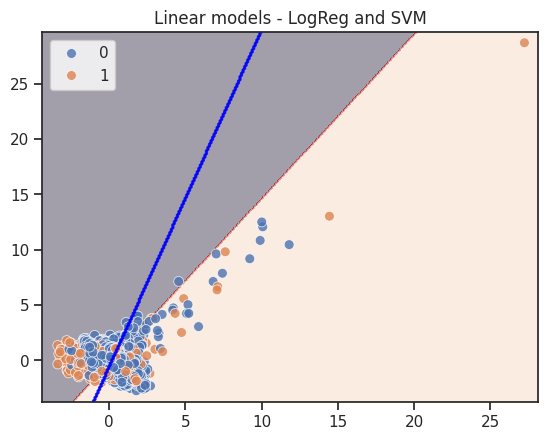

In [165]:
# Fitting SVM model on 2 features
svm.fit(X, y)

# Plotting decision boundary for LR
z1 = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z1 = z1.reshape(xx.shape)

# Plotting decision boundary for SVM
z2 = svm.predict(np.c_[xx.ravel(), yy.ravel()])
z2 = z2.reshape(xx.shape)

# Displaying the result
plt.contourf(xx, yy, z1, alpha=0.4)  # LR
plt.contour(xx, yy, z2, alpha=0.4, colors='blue')  # SVM
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_train, s=50, alpha=0.8)
plt.title('Linear models - LogReg and SVM')


In [166]:
#More baseline models (Non-linear) : Decision Tree
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

weights_dict = {0: 1.0, 1: 3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [167]:
## Features selected from the RFE process
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [168]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train[selected_feats_dt].values
X_val = df_val[selected_feats_dt].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 10), (7920,))

((1080, 10), (1080,))

In [169]:
clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

In [170]:
## Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

features  importance
2  bal_by_est_salary    0.476857
3             Tenure    0.351836
0                Age    0.096427
7     country_France    0.043623
1        CreditScore    0.028357
4     IsActiveMember    0.002900
5             Gender    0.000000
6    country_Germany    0.000000
8      NumOfProducts    0.000000
9      country_Spain    0.000000

In [171]:
## Training metrics
roc_auc_score(y_train, clf.predict(X_train))
recall_score(y_train, clf.predict(X_train))
confusion_matrix(y_train, clf.predict(X_train))
print(classification_report(y_train, clf.predict(X_train)))

0.7514707829672929

0.7369402985074627

array([[4835, 1477],
       [ 423, 1185]])

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      6312
           1       0.45      0.74      0.56      1608

    accuracy                           0.76      7920
   macro avg       0.68      0.75      0.70      7920
weighted avg       0.82      0.76      0.78      7920



In [172]:
## Validation metrics
roc_auc_score(y_val, clf.predict(X_val))
recall_score(y_val, clf.predict(X_val))
confusion_matrix(y_val, clf.predict(X_val))
print(classification_report(y_val, clf.predict(X_val)))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]])

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



In [173]:
#Plot decision boundaries of non-linear model
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## Transforming the dataset using PCA
X = pca.fit_transform(X_train)
y = y_train
X_train.shape
X.shape
y.shape


(7920, 10)

(7920, 2)

(7920,)

In [174]:
## Checking the variance explained by the reduced features
pca.explained_variance_ratio_

array([0.51069916, 0.48930078])

In [175]:
# Creating a mesh region where the boundary will be plotted
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 100),
                     np.arange(y_min, y_max, 100))

In [176]:
## Fitting tree model on 2 features
clf.fit(X, y)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

<Axes: >

Text(0.5, 1.0, 'Decision Tree')

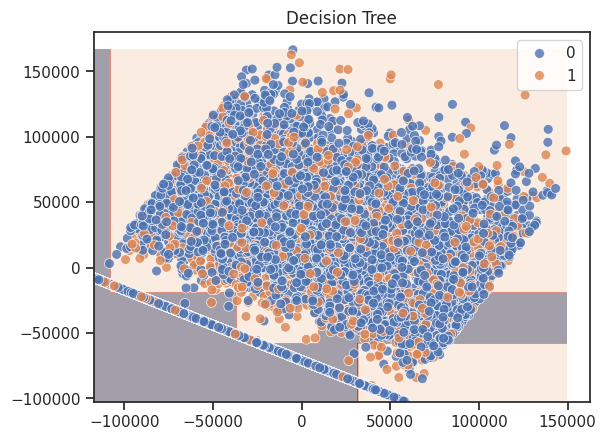

In [177]:
## Plotting decision boundary for Decision Tree (DT)
z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# Displaying the result for Decision Tree
plt.contourf(xx, yy, z, alpha=0.4)  # DT
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_train, s=50, alpha=0.8)
plt.title('Decision Tree')

In [178]:
#Decision tree rule engine visualization

from sklearn.tree import export_graphviz
import subprocess

clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 3, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=3, min_samples_leaf=15, min_samples_split=25)

In [179]:
## Export as dot file
dot_data = export_graphviz(clf, out_file = 'tree.dot'
                          , feature_names = selected_feats_dt
                          , class_names = ['Did not churn', 'Churned']
                          , rounded = True, proportion = False
                          , precision = 2, filled = True)
## Convert to png using system command (requires Graphviz)
subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'])

CompletedProcess(args=['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'], returncode=0)

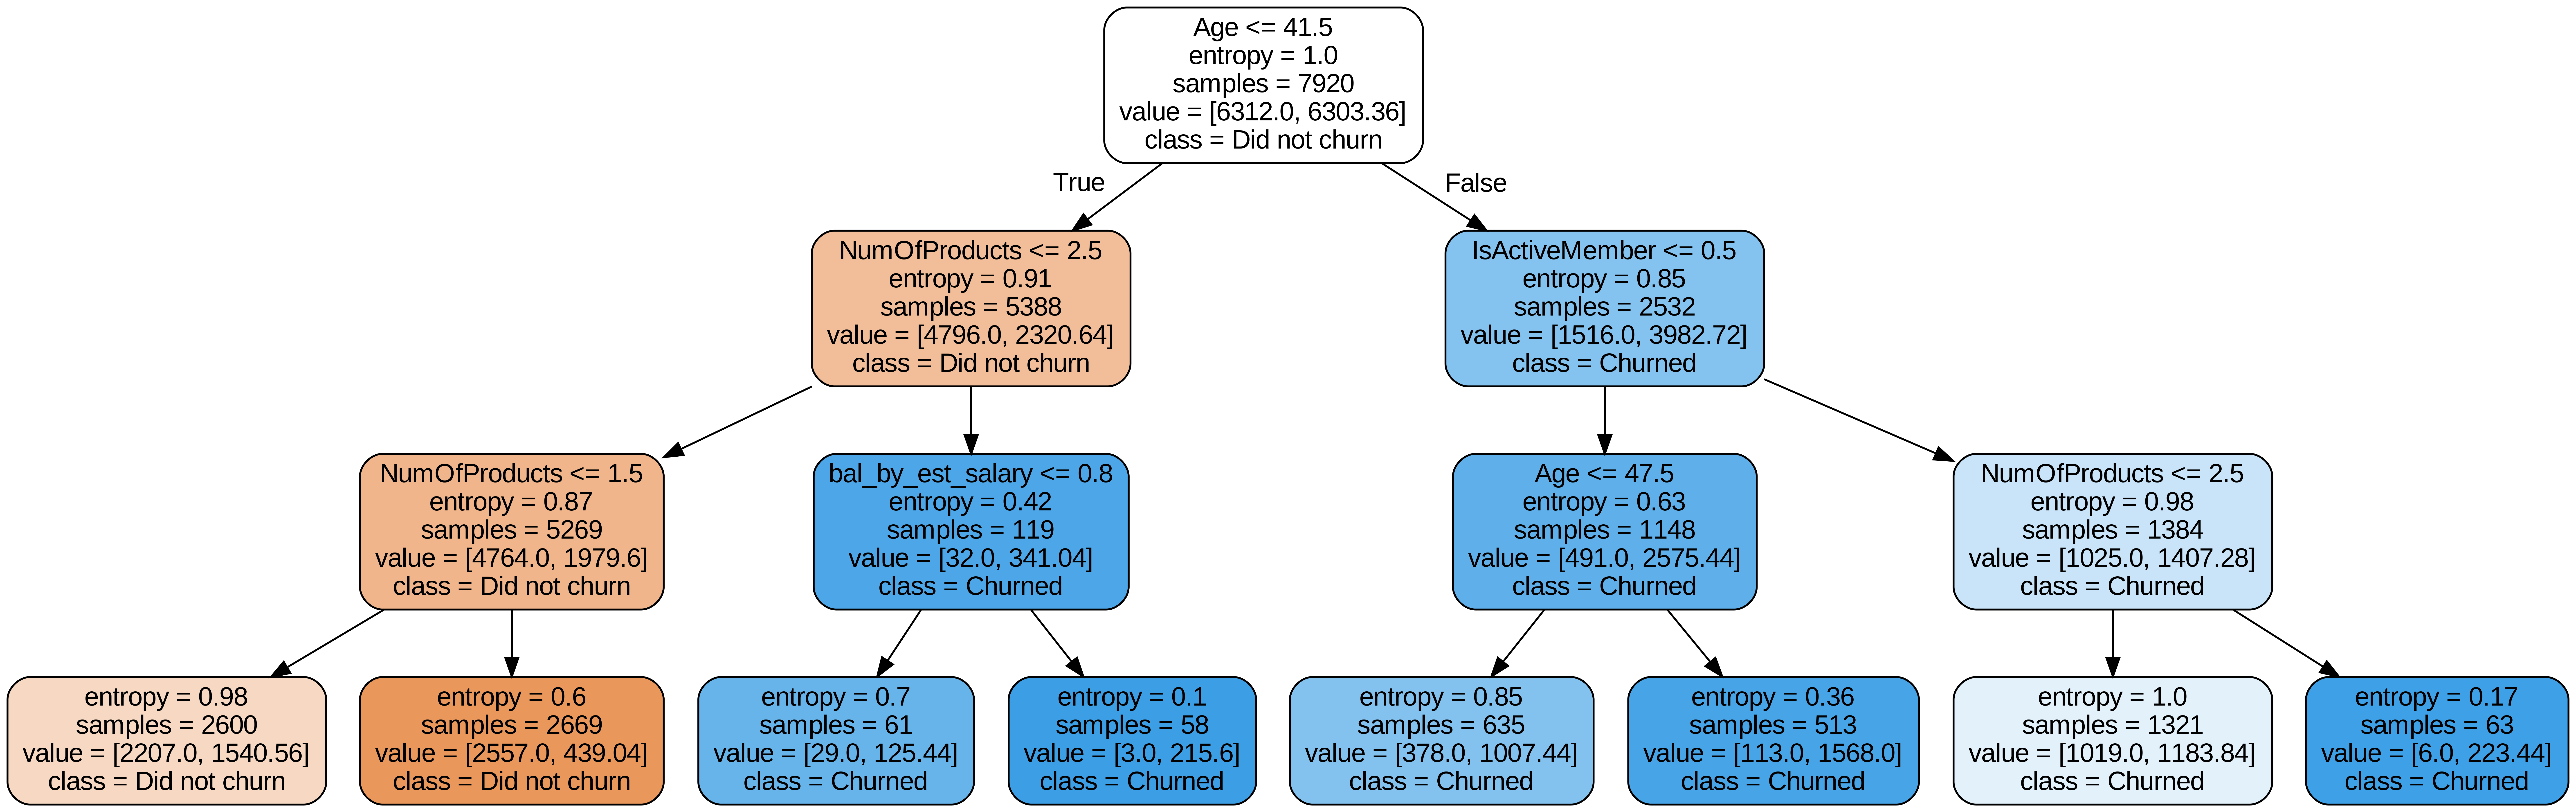

In [180]:
## Display the rule-set of a single tree
from IPython.display import Image
Image(filename = 'tree.png')

In [181]:
##Automating data preparation and model run through Pipelines

from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)

    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """

        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N
            categories). E.g. for a column with categories A, B,
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0],
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False

        """

        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols

        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols

        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols

        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols

        self.reduce_df = reduce_df


    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.

        Returns
        -------
        self : encoder
            Returns self.
        """

        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]

        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]

        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]


        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))


        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]


        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())


        ## Return the fit object
        return self


    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():

            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1


        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]


        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular
                                                                                 # category level occurs only once in the dataset

                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean


        ## Return encoded DataFrame
        return Xo


    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        return self.fit(X, y).transform(X, y)


In [182]:
class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """

    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """

        self.eps = eps


    def fit(self, X, y=None):
        return self


    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname_enc

        ## Returning the updated dataframe
        return Xo


    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)


In [183]:
class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """

    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns

        """
        self.scale_cols = scale_cols


    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """

        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if ((str(X[c].dtype).find('float') != -1) or (str(X[c].dtype).find('int') != -1))]


        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)

        # Return fit object
        return self


    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()

        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']


        # Return scaled and normalized DataFrame
        return Xo


    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)

In [184]:
#Pipeline in action for a single model

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report



X = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

weights_dict = {0 : 1.0, 1 : 3.92}

clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', clf)
                         ])

# Fit pipeline with training data
model.fit(X,y_train)


Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('standard_scaling',
                 CustomScaler(scale_cols=['CreditScore', 'Age', 'Balance',
                                          'EstimatedSalary', 'bal_per_product',
                                          'bal_by_est_salary',
                                          'tenure_age_ratio',
                                          'age_surname_enc'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92},
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=15,
                                        min_samples_split=25))])

In [185]:
# Predict target values on val data
val_preds = model.predict(X_val)

## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]])

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



In [186]:
#Model Zoo + k-fold Cross Validation
#
#Models : RF, LGBM, XGB, Naive Bayes (Gaussian/Multinomial), kNN

from sklearn.model_selection import cross_val_score


## Preparing data and a few common model parameters
X = df_train.drop(columns = ['Exited'], axis = 1)
y = y_train.ravel()

weights_dict = {0 : 1.0, 1 : 3.93}
_, num_samples = np.unique(y_train, return_counts = True)
weight = (num_samples[0]/num_samples[1]).round(2)
weight

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']


3.93

In [187]:
## Importing the models to be tried out
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

## Preparing a list of models to try out in the spot-checking process
def model_zoo(models = dict()):
    # Tree models
    for n_trees in [21, 1001]:
        models['rf_' + str(n_trees)] = RandomForestClassifier(n_estimators = n_trees, n_jobs = -1, criterion = 'entropy'
                                                              , class_weight = weights_dict, max_depth = 6, max_features = 0.6
                                                              , min_samples_split = 30, min_samples_leaf = 20)

        models['lgb_' + str(n_trees)] = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1
                                                       , n_estimators=n_trees, class_weight=weights_dict, min_child_samples=20
                                                       , colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=- 1
                                                       , importance_type = 'gain')

        models['xgb_' + str(n_trees)] = XGBClassifier(objective='binary:logistic', n_estimators = n_trees, max_depth = 6
                                                      , learning_rate = 0.03, n_jobs = -1, colsample_bytree = 0.6
                                                      , reg_alpha = 0.3, reg_lambda = 0.1, scale_pos_weight = weight)

        models['et_' + str(n_trees)] = ExtraTreesClassifier(n_estimators=n_trees, criterion = 'entropy', max_depth = 6
                                                            , max_features = 0.6, n_jobs = -1, class_weight = weights_dict
                                                            , min_samples_split = 30, min_samples_leaf = 20)

    # kNN models
    for n in [3,5,11]:
        models['knn_' + str(n)] = KNeighborsClassifier(n_neighbors=n)

    # Naive-Bayes models
    models['gauss_nb'] = GaussianNB()
    models['multi_nb'] = MultinomialNB()
    models['compl_nb'] = ComplementNB()
    models['bern_nb'] = BernoulliNB()

    return models

In [188]:
## Automation of data preparation and model run through pipelines
def make_pipeline(model):
    '''
    Creates pipeline for the model passed as the argument. Uses standard scaling only in case of kNN models.
    Ignores scaling step for tree/Naive Bayes models
    '''

    if (str(model).find('KNeighborsClassifier') != -1):
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('standard_scaling', CustomScaler(cols_to_scale)),
                              ('classifier', model)
                             ])
    else :
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('classifier', model)
                             ])


    return pipe

In [189]:
## Run/Evaluate all 15 models using KFold cross-validation (5 folds)
def evaluate_models(X, y, models, folds = 5, metric = 'recall'):
    results = dict()
    for name, model in models.items():
        # Evaluate model through automated pipelines
        pipeline = make_pipeline(model)
        scores = cross_val_score(pipeline, X, y, cv = folds, scoring = metric, n_jobs = -1)

        # Store results of the evaluated model
        results[name] = scores
        mu, sigma = np.mean(scores), np.std(scores)
        # Printing individual model results
        print('Model {}: mean = {}, std_dev = {}'.format(name, mu, sigma))

    return results

## Spot-checking in action
models = model_zoo()
print('Recall metric')
results = evaluate_models(X, y , models, metric = 'recall')
print('F1-score metric')
results = evaluate_models(X, y , models, metric = 'f1')

Recall metric
Model rf_21: mean = 0.7475087556355333, std_dev = 0.014829494250763693
Model lgb_21: mean = 0.7866856291480427, std_dev = 0.015745566437193475
Model xgb_21: mean = 0.7798339815406049, std_dev = 0.021729844580640357
Model et_21: mean = 0.7400437298039899, std_dev = 0.007455606456578212
Model rf_1001: mean = 0.7468740929935566, std_dev = 0.025307449130950118
Model lgb_1001: mean = 0.6884232116251622, std_dev = 0.014573973874519829
Model xgb_1001: mean = 0.6772237379307675, std_dev = 0.019457383147243705
Model et_1001: mean = 0.7363189566765349, std_dev = 0.005985075013889205
Model knn_3: mean = 0.32214933921557243, std_dev = 0.021051639994704833
Model knn_5: mean = 0.2879356049612043, std_dev = 0.006396680440459953
Model knn_11: mean = 0.23568622898163735, std_dev = 0.023099705052575383
Model gauss_nb: mean = 0.0360906329211896, std_dev = 0.0151162576177723
Model multi_nb: mean = 0.5404191095373541, std_dev = 0.022285871235774777
Model compl_nb: mean = 0.5404191095373541, s

**Hyperparameter tuning**
---
**RandomSearchCV vs GridSearchCV**

In [190]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

In [191]:
## Preparing data and a few common model parameters
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [192]:
lgb = LGBMClassifier(boosting_type = 'dart', min_child_samples = 20, n_jobs = - 1, importance_type = 'gain', num_leaves = 31)
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

Randomized Search

In [193]:
## Exhaustive list of parameters
parameters = {'classifier__n_estimators':[10, 21, 51, 100, 201, 350, 501]
             ,'classifier__max_depth': [3, 4, 6, 9]
             ,'classifier__num_leaves':[7, 15, 31]
             ,'classifier__learning_rate': [0.03, 0.05, 0.1, 0.5, 1]
             ,'classifier__colsample_bytree': [0.3, 0.6, 0.8]
             ,'classifier__reg_alpha': [0, 0.3, 1, 5]
             ,'classifier__reg_lambda': [0.1, 0.5, 1, 5, 10]
             ,'classifier__class_weight': [{0:1,1:1.0}, {0:1,1:1.96}, {0:1,1:3.0}, {0:1,1:3.93}]
             }

In [194]:
search = RandomizedSearchCV(model, parameters, n_iter = 20, cv = 5, scoring = 'f1')
search.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1287, number of negative: 5049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 6336, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500441 -> initscore=0.001763
[LightGBM] [Info] Start training from score 0.001763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1287, number of negative: 5049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the o

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('categorical_encoding',
                                              CategoricalEncoder()),
                                             ('add_new_features',
                                              AddFeatures()),
                                             ('classifier',
                                              LGBMClassifier(boosting_type='dart',
                                                             importance_type='gain',
                                                             n_jobs=-1))]),
                   n_iter=20,
                   param_distributions={'classifier__class_weight': [{0: 1,
                                                                      1: 1.0},
                                                                     {0: 1,
                                                                      1: 1.96},
                                                                     {0: 1,
                                                                      1: 3.0},
                                                                     {0: 1,
                                                                      1: 3.93}],
                                        'classifier__colsample_bytree': [0.3,
                                                                         0.6,
                                                                         0.8],
                                        'classifier__learning_rate': [0.03,
                                                                      0.05, 0.1,
                                                                      0.5, 1],
                                        'classifier__max_depth': [3, 4, 6, 9],
                                        'classifier__n_estimators': [10, 21, 51,
                                                                     100, 201,
                                                                     350, 501],
                                        'classifier__num_leaves': [7, 15, 31],
                                        'classifier__reg_alpha': [0, 0.3, 1, 5],
                                        'classifier__reg_lambda': [0.1, 0.5, 1,
                                                                   5, 10]},
                   scoring='f1')

In [195]:
search.best_params_
search.best_score_
search.cv_results_

{'classifier__reg_lambda': 0.1,
 'classifier__reg_alpha': 0.3,
 'classifier__num_leaves': 7,
 'classifier__n_estimators': 501,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 0.8,
 'classifier__class_weight': {0: 1, 1: 1.96}}

0.692487120441292

{'mean_fit_time': array([0.03978424, 0.04071522, 1.31627841, 2.59863696, 3.42289662,
        0.15166602, 0.07577167, 0.7068285 , 0.56748571, 0.90194502,
        0.09202542, 0.51915264, 0.04234128, 0.18778806, 0.62234087,
        0.54908156, 0.33100734, 0.12525578, 0.04697361, 1.25615683]),
 'std_fit_time': array([0.00360251, 0.00339742, 0.02691164, 0.71353482, 0.90260915,
        0.00938245, 0.00491802, 0.00835066, 0.01650995, 0.74833272,
        0.00826205, 0.00793405, 0.00376043, 0.00482044, 0.01114977,
        0.60903947, 0.01145722, 0.00289716, 0.00264654, 0.01633725]),
 'mean_score_time': array([0.01077237, 0.00879722, 0.02139435, 0.03799314, 0.03023996,
        0.01230812, 0.01013117, 0.0206984 , 0.01780448, 0.02623477,
        0.00991516, 0.01571126, 0.0085093 , 0.01306014, 0.01931901,
        0.01757483, 0.01636291, 0.01010828, 0.01214948, 0.02143855]),
 'std_score_time': array([0.00334406, 0.00051174, 0.00044797, 0.01411296, 0.00090645,
        0.00039235, 0.00040692, 0.002452

Grid Search

In [196]:
## Current list of parameters
parameters = {'classifier__n_estimators':[201]
             ,'classifier__max_depth': [6]
             ,'classifier__num_leaves': [63]
             ,'classifier__learning_rate': [0.1]
             ,'classifier__colsample_bytree': [0.6, 0.8]
             ,'classifier__reg_alpha': [0, 1, 10]
             ,'classifier__reg_lambda': [0.1, 1, 5]
             ,'classifier__class_weight': [{0:1,1:3.0}]
             }


In [197]:
grid = GridSearchCV(model, parameters, cv = 5, scoring = 'f1', n_jobs = -1)
grid.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoding',
                                        CategoricalEncoder()),
                                       ('add_new_features', AddFeatures()),
                                       ('classifier',
                                        LGBMClassifier(boosting_type='dart',
                                                       importance_type='gain',
                                                       n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [{0: 1, 1: 3.0}],
                         'classifier__colsample_bytree': [0.6, 0.8],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [6],
                         'classifier__n_estimators': [201],
                         'classifier__num_leaves': [63],
                         'classifier__reg_alpha': [0, 1, 10],
                         'classifier__reg_lambda': [0.1, 1, 5]},
             scoring='f1')

In [198]:
grid.best_params_
grid.best_score_
grid.cv_results_

{'classifier__class_weight': {0: 1, 1: 3.0},
 'classifier__colsample_bytree': 0.6,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 201,
 'classifier__num_leaves': 63,
 'classifier__reg_alpha': 1,
 'classifier__reg_lambda': 1}

0.6827227378996369

{'mean_fit_time': array([22.0760994 , 17.64162412, 14.86173038, 17.71899719, 17.63996258,
        18.47532945, 15.39928331, 11.9791853 , 17.66208129, 14.45659175,
        16.60382524, 16.65048084, 14.30054932, 19.02674584, 21.22967834,
        19.53253551, 20.58344107, 16.35175819]),
 'std_fit_time': array([6.53059692, 3.35094837, 2.6406549 , 2.98093495, 2.39459476,
        4.60487111, 3.13431941, 2.71964832, 5.85558229, 3.14155393,
        6.11289817, 4.95487296, 1.13824111, 1.35133453, 4.2533467 ,
        6.7637418 , 6.19890821, 4.84571189]),
 'mean_score_time': array([0.05380201, 0.06200485, 0.04424567, 0.05389929, 0.04727383,
        0.06053677, 0.0559248 , 0.0739399 , 0.05891953, 0.04343743,
        0.04202061, 0.04505315, 0.05142817, 0.04367161, 0.05102901,
        0.04288664, 0.05187035, 0.04591346]),
 'std_score_time': array([0.00871202, 0.0146659 , 0.00620141, 0.02317402, 0.01093561,
        0.02482815, 0.02358617, 0.02666125, 0.02489678, 0.00462741,
        0.00500762, 0.0023

Ensembles


In [199]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

## Preparing data for error analysis
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [200]:
## Three versions of the final model with best params for F1-score metric

# Equal weights to both target classes (no class imbalance correction)
lgb1 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 1}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 4, num_leaves = 31, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 21, reg_alpha = 0, reg_lambda = 0.5)

# Addressing class imbalance completely by weighting the undersampled class by the class imbalance ratio
lgb2 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.93}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


# Best class_weight parameter settings (partial class imbalance correction)
lgb3 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)



## 3 different Pipeline objects for the 3 models defined above
model_1 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb1)
                         ])

model_2 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb2)
                         ])

model_3 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb3)
                         ])



## Fitting each of these models
model_1.fit(X_train, y_train.ravel())
model_2.fit(X_train, y_train.ravel())
model_3.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203030 -> initscore=-1.367461
[LightGBM] [Info] Start training from score -1.367461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 1},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=4, n_estimators=21, n_jobs=-1,
                                reg_alpha=0, reg_lambda=0.5))])

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500295 -> initscore=0.001178
[LightGBM] [Info] Start training from score 0.001178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.93},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

In [201]:
## Getting prediction probabilities from each of these models
m1_pred_probs_trn = model_1.predict_proba(X_train)
m2_pred_probs_trn = model_2.predict_proba(X_train)
m3_pred_probs_trn = model_3.predict_proba(X_train)

## Checking correlations between the predictions of the 3 models
df_t = pd.DataFrame({'m1_pred': m1_pred_probs_trn[:,1], 'm2_pred': m2_pred_probs_trn[:,1], 'm3_pred': m3_pred_probs_trn[:,1]})
df_t.shape
df_t.corr()

(7920, 3)

m1_pred   m2_pred   m3_pred
m1_pred  1.000000  0.894747  0.911251
m2_pred  0.894747  1.000000  0.994593
m3_pred  0.911251  0.994593  1.000000

In [202]:
## Importing relevant metric libraries
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

## Getting prediction probabilities from each of these models
m1_pred_probs_val = model_1.predict_proba(X_val)
m2_pred_probs_val = model_2.predict_proba(X_val)
m3_pred_probs_val = model_3.predict_proba(X_val)


threshold = 0.5

## Best model (Model 3) predictions
m3_preds = np.where(m3_pred_probs_val[:,1] >= threshold, 1, 0)

## Model averaging predictions (Weighted average)
m1_m2_preds = np.where(((0.1*m1_pred_probs_val[:,1]) + (0.9*m2_pred_probs_val[:,1])) >= threshold, 1, 0)

## Model 3 (Best model, tuned by GridSearch) performance on validation set
roc_auc_score(y_val, m3_preds)
recall_score(y_val, m3_preds)
confusion_matrix(y_val, m3_preds)
print(classification_report(y_val, m3_preds))

0.7469310764685922

0.592436974789916

array([[759,  83],
       [ 97, 141]])

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.59      0.61       238

    accuracy                           0.83      1080
   macro avg       0.76      0.75      0.75      1080
weighted avg       0.83      0.83      0.83      1080



In [203]:
## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))

0.7586678376813908

0.6218487394957983

array([[754,  88],
       [ 90, 148]])

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.62      0.62       238

    accuracy                           0.84      1080
   macro avg       0.76      0.76      0.76      1080
weighted avg       0.83      0.84      0.83      1080



Model stacking

In [204]:
from sklearn.linear_model import LogisticRegression

## Training
lr = LogisticRegression(C = 1.0, class_weight =  {0:1, 1:2.0})

# Concatenating the probability predictions of the 2 models on train set
X_t = np.c_[m1_pred_probs_trn[:,1],m2_pred_probs_trn[:,1]]

# Fit stacker model on top of outputs of base model
lr.fit(X_t, y_train)

LogisticRegression(class_weight={0: 1, 1: 2.0})

In [205]:
## Prediction
# Concatenating outputs from both the base models on the validation set
X_t_val = np.c_[m1_pred_probs_val[:,1],m2_pred_probs_val[:,1]]

# Predict using the stacker model
m1_m2_preds = lr.predict(X_t_val)

## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))


0.7463372522405638

0.592436974789916

array([[758,  84],
       [ 97, 141]])

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.59      0.61       238

    accuracy                           0.83      1080
   macro avg       0.76      0.75      0.75      1080
weighted avg       0.83      0.83      0.83      1080



In [206]:
# Model weights learnt by the stacker LogReg model
lr.coef_
lr.intercept_

array([[-6.06252409, 12.94656529]])

array([-5.65280526])

Error analysis

In [207]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline


## Preparing data for error analysis
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [208]:
## Final model with best params for F1-score metric

lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

In [209]:
## Fit best model
model.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

In [210]:
## Making predictions on a copy of validation set
df_ea = df_val.copy()
df_ea['y_pred'] = model.predict(X_val)
df_ea['y_pred_prob'] = model.predict_proba(X_val)[:,1]
df_ea.shape
df_ea.sample(5)

(1080, 20)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
220          553       1   35       2  158584.28              2          1   
323          724       0   29       6       0.00              2          0   
799          684       1   35       6  135871.50              1          1   
930          591       1   58       5  128468.69              1          0   
461          627       1   30       3  128770.88              2          1   

     IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
220               0         43640.16       0             0.0              1.0   
323               1         64729.51       0             1.0              0.0   
799               1         87219.41       0             1.0              0.0   
930               1        137254.55       0             0.0              0.0   
461               1         40199.01       0             0.0              1.0   

     country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
220            0.0     0.400000     79292.100354           3.633907   
323            0.0     0.200000         0.000000           0.000000   
799            0.0     0.133333    135871.364129           1.557813   
930            1.0     0.203030    128468.561531           0.935989   
461            0.0     0.500000     64385.407807           3.203335   

     tenure_age_ratio  age_surname_mean_churn  y_pred  y_pred_prob  
220          0.057143                2.366432       0     0.131931  
323          0.206897                1.077033       0     0.049337  
799          0.171429                0.788811       0     0.133682  
930          0.086207                1.546233       0     0.089909  
461          0.100000                2.738613       0     0.139786

<Axes: >

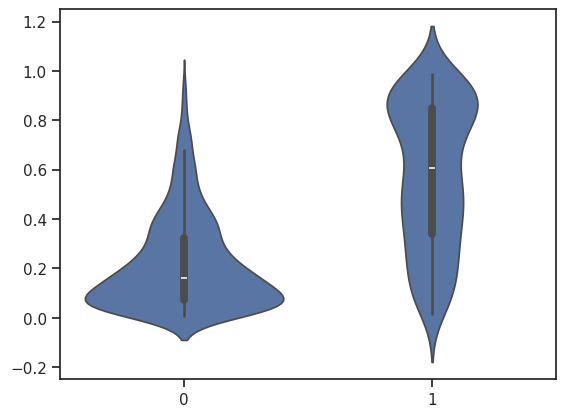

In [213]:
## Visualizing distribution of predicted probabilities
sns.violinplot(x=y_val.ravel(), y=df_ea['y_pred_prob'].values)

<Axes: xlabel='Exited', ylabel='Age'>

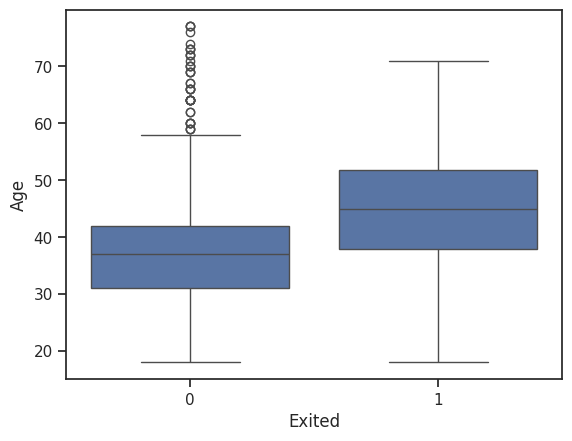

In [214]:
sns.boxplot(x = 'Exited', y = 'Age', data = df_ea)

In [215]:
## Are we able to correctly identify pockets of high-churn customer regions in feature space?
df_ea.Exited.value_counts(normalize=True).sort_index()
df_ea[(df_ea.Age > 42) & (df_ea.Age < 53)].Exited.value_counts(normalize=True).sort_index()
df_ea[(df_ea.Age > 42) & (df_ea.Age < 53)].y_pred.value_counts(normalize=True).sort_index()

0    0.77963
1    0.22037
Name: Exited, dtype: float64

0    0.560185
1    0.439815
Name: Exited, dtype: float64

0    0.481481
1    0.518519
Name: y_pred, dtype: float64

In [218]:
## Checking correlation between features and target variable vs predicted variable
x = df_ea[num_feats + ['y_pred', 'Exited']].corr()
x[['y_pred','Exited']]

y_pred    Exited
CreditScore     -0.016600 -0.026118
Age              0.364415  0.290853
Tenure          -0.015095 -0.011182
Balance          0.065750  0.128656
NumOfProducts   -0.150982 -0.125494
EstimatedSalary  0.006502 -0.007971
y_pred           1.000000  0.504881
Exited           0.504881  1.000000

In [217]:
low_recall = df_ea[(df_ea.Exited == 1) & (df_ea.y_pred == 0)]
low_prec = df_ea[(df_ea.Exited == 0) & (df_ea.y_pred == 1)]
low_recall.shape
low_prec.shape
low_recall.head()
low_prec.head()

(97, 20)

(83, 20)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
5           706       0   23       5       0.00              1          0   
21          611       1   35      10       0.00              1          1   
38          491       0   68       1   95039.12              1          0   
58          637       1   43       1  135645.29              2          0   
92          717       0   36       2   99472.76              2          1   

    IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
5                0        164128.41       1             1.0              0.0   
21               1         23598.23       1             1.0              0.0   
38               1        116471.14       1             0.0              1.0   
58               1        101382.86       1             0.0              1.0   
92               0         94274.72       1             1.0              0.0   

    country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
5             0.0     0.000000         0.000000           0.000000   
21            0.0     0.153846         0.000000           0.000000   
38            0.0     0.000000     95039.024961           0.815989   
58            0.0     0.090909     67822.611089           1.337951   
92            0.0     0.222222     49736.355132           1.055137   

    tenure_age_ratio  age_surname_mean_churn  y_pred  y_pred_prob  
5           0.217391                0.000000       0     0.376791  
21          0.285714                0.910166       0     0.261700  
38          0.014706                0.000000       0     0.417236  
58          0.023256                0.596131       0     0.481300  
92          0.055556                1.333333       0     0.092277

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
48          512       1   39       3       0.00              1          1   
49          736       1   43       4  202443.47              1          1   
57          505       1   43       6  127146.68              1          0   
75          648       1   41       5  123049.21              1          0   
99          631       1   51       8  100654.80              1          1   

    IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
48               0        134878.19       0             0.0              0.0   
49               0         72375.03       0             1.0              0.0   
57               0        137565.87       0             0.0              1.0   
75               1          5066.76       0             0.0              1.0   
99               0        171587.90       0             1.0              0.0   

    country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
48            1.0     0.083333         0.000000           0.000000   
49            0.0     0.000000    202443.267557           2.797145   
57            0.0     0.090909    127146.552853           0.924260   
75            0.0     0.142857    123049.086951          24.285581   
99            0.0     0.500000    100654.699345           0.586608   

    tenure_age_ratio  age_surname_mean_churn  y_pred  y_pred_prob  
48          0.076923                0.520416       1     0.597483  
49          0.093023                0.000000       1     0.654514  
57          0.139535                0.596131       1     0.786853  
75          0.121951                0.914732       1     0.668350  
99          0.156863                3.570714       1     0.821969

<ipython-input-219-104df264d001>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(low_recall.y_pred_prob, hist=False)


<Axes: xlabel='y_pred_prob', ylabel='Density'>

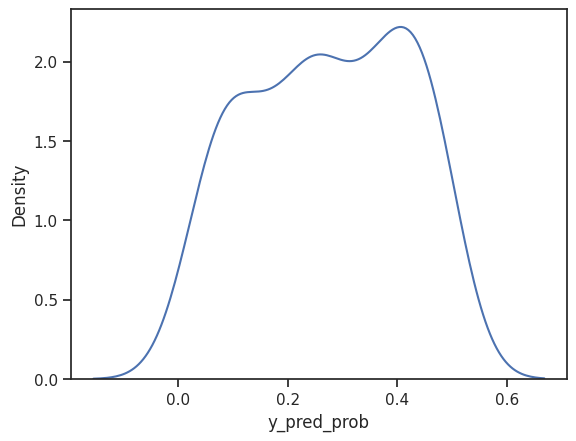

In [219]:
## Prediction probabilty distribution of errors causing low recall
sns.distplot(low_recall.y_pred_prob, hist=False)

<ipython-input-220-3c88cd2e9a56>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(low_prec.y_pred_prob, hist=False)


<Axes: xlabel='y_pred_prob', ylabel='Density'>

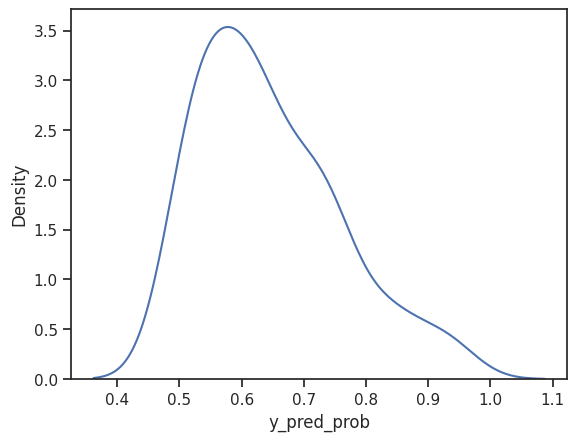

In [220]:
## Prediction probabilty distribution of errors causing low precision
sns.distplot(low_prec.y_pred_prob, hist=False)

Tweaking the threshold of classifier

In [221]:
threshold = 0.55

## Predict on validation set with adjustable decision threshold
probs = model.predict_proba(X_val)[:,1]
val_preds = np.where(probs > threshold, 1, 0)

## Default params : 0.5 threshold
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

array([[778,  64],
       [110, 128]])

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       842
           1       0.67      0.54      0.60       238

    accuracy                           0.84      1080
   macro avg       0.77      0.73      0.75      1080
weighted avg       0.83      0.84      0.83      1080



In [222]:
## Tweaking threshold between 0.4 and 0.6
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

array([[778,  64],
       [110, 128]])

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       842
           1       0.67      0.54      0.60       238

    accuracy                           0.84      1080
   macro avg       0.77      0.73      0.75      1080
weighted avg       0.83      0.84      0.83      1080



In [223]:
df_ea.NumOfProducts.value_counts(normalize=True).sort_index()
low_recall.NumOfProducts.value_counts(normalize=True).sort_index()
low_prec.NumOfProducts.value_counts(normalize=True).sort_index()

1    0.506481
2    0.467593
3    0.020370
4    0.005556
Name: NumOfProducts, dtype: float64

1    0.701031
2    0.288660
3    0.010309
Name: NumOfProducts, dtype: float64

1    0.819277
2    0.156627
3    0.024096
Name: NumOfProducts, dtype: float64

In [224]:
df_ea.IsActiveMember.value_counts(normalize=True).sort_index()
low_recall.IsActiveMember.value_counts(normalize=True).sort_index()
low_prec.IsActiveMember.value_counts(normalize=True).sort_index()

0    0.481481
1    0.518519
Name: IsActiveMember, dtype: float64

0    0.556701
1    0.443299
Name: IsActiveMember, dtype: float64

0    0.626506
1    0.373494
Name: IsActiveMember, dtype: float64

<Axes: ylabel='Age'>

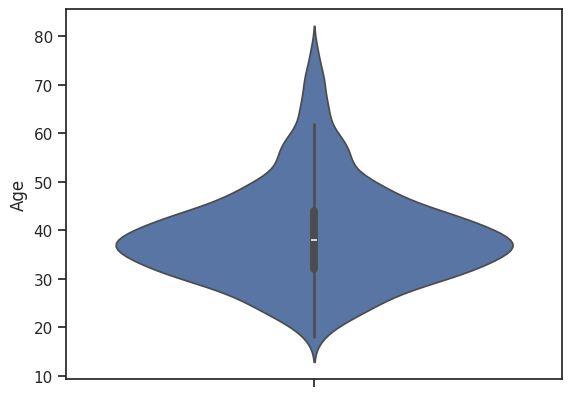

In [225]:
sns.violinplot(y = df_ea.Age)

<Axes: ylabel='Age'>

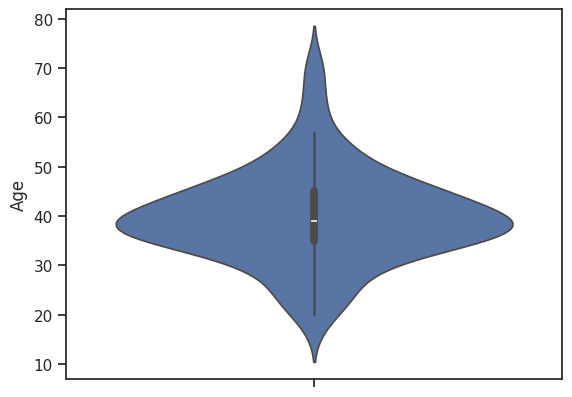

In [226]:
sns.violinplot(y = low_recall.Age)

<Axes: ylabel='Age'>

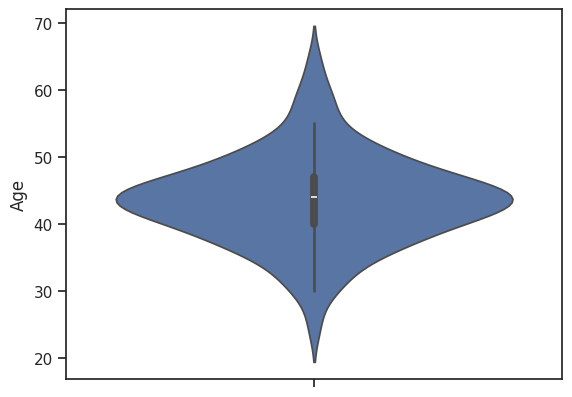

In [227]:
sns.violinplot(y = low_prec.Age)

<Axes: ylabel='Balance'>

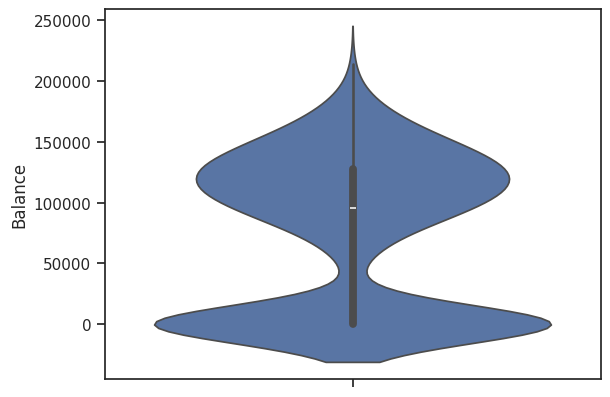

In [228]:
sns.violinplot(y = df_ea.Balance)

<Axes: ylabel='Balance'>

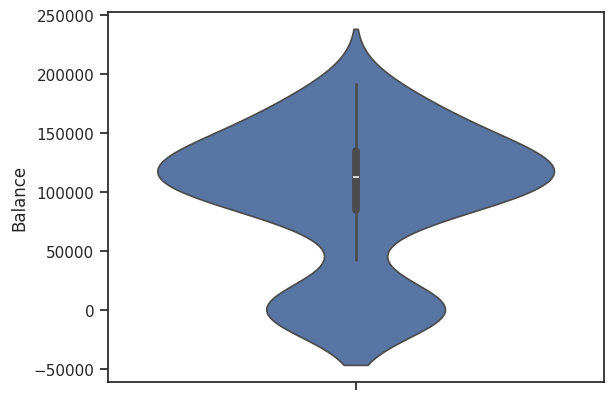

In [229]:
sns.violinplot(y = low_recall.Balance)

<Axes: ylabel='Balance'>

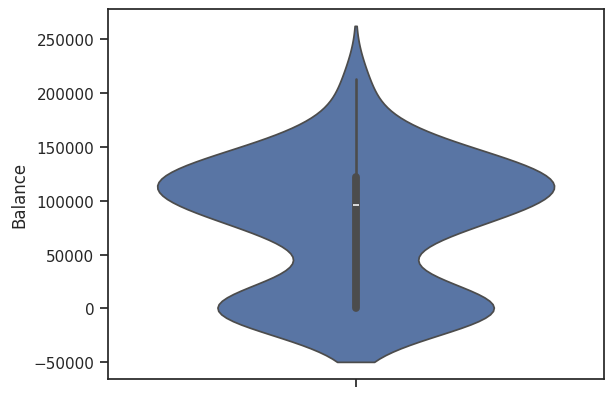

In [230]:
sns.violinplot(y = low_prec.Balance)

Train final model and Save the model and its parameters

In [231]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report
import joblib


## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [232]:
best_f1_lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)

best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1, n_estimators = 21
                                 , class_weight= {0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3
                                 , reg_lambda=1.0, n_jobs=- 1, importance_type = 'gain')

model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])

## Fitting final model on train dataset
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

<Axes: xlabel='Target', ylabel='Predicted_Prob'>

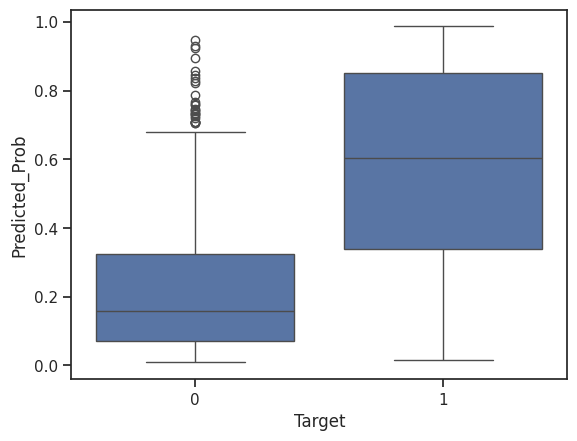

In [234]:
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

# Predict target values on val data
val_preds = np.where(val_probs > 0.45, 1, 0) # The probability threshold can be tweaked

# Create a DataFrame with target values and predicted probabilities
data_for_boxplot = pd.DataFrame({'Target': y_val.ravel(), 'Predicted_Prob': val_probs})

# Use boxplot with 'Target' as the x-axis variable and 'Predicted_Prob' as the y-axis variable
sns.boxplot(x='Target', y='Predicted_Prob', data=data_for_boxplot)


In [235]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7587576598335297

0.6386554621848739

array([[740, 102],
       [ 86, 152]])

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       842
           1       0.60      0.64      0.62       238

    accuracy                           0.83      1080
   macro avg       0.75      0.76      0.75      1080
weighted avg       0.83      0.83      0.83      1080



In [236]:
## Save model object
joblib.dump(model, 'final_churn_model_f1_0_45.sav')

['final_churn_model_f1_0_45.sav']

SHAP

In [237]:
import shap

shap.initjs()


ce = CategoricalEncoder()
af = AddFeatures()

X = ce.fit_transform(X_train, y_train)
X = af.transform(X)

X.shape
X.sample(5)

(7920, 18)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
5450          727       0   49       7   96296.78              1          1   
3543          560       1   49       4       0.00              1          1   
4982          572       1   39       4  112290.22              1          1   
2267          771       1   50       3  105229.72              1          1   
4054          516       1   37       8       0.00              1          1   

      IsActiveMember  EstimatedSalary  country_France  country_Germany  \
5450               0        190457.87             0.0              0.0   
3543               1        100075.10             1.0              0.0   
4982               0         49373.97             0.0              1.0   
2267               1         16281.68             1.0              0.0   
4054               0        101834.58             1.0              0.0   

      country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
5450            1.0     0.000000     96296.683703           0.505607   
3543            0.0     0.333333         0.000000           0.000000   
4982            0.0     0.333333    112290.107710           2.274280   
2267            0.0     0.333333    105229.614770           6.463075   
4054            0.0     0.285714         0.000000           0.000000   

      tenure_age_ratio  age_surname_mean_churn  age_surname_enc  
5450          0.142857                0.000000         0.000000  
3543          0.081633                2.333333         2.333333  
4982          0.102564                2.081666         2.081666  
2267          0.060000                2.357023         2.357023  
4054          0.216216                1.737932         1.737932

In [238]:
best_f1_lgb.fit(X, y_train)

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 3.0},
               colsample_bytree=0.6, importance_type='gain', max_depth=6,
               n_estimators=201, n_jobs=-1, num_leaves=63, reg_alpha=1,
               reg_lambda=1)

In [239]:
explainer = shap.TreeExplainer(best_f1_lgb)
X.head(5)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          678       1   36       1  117864.85              2          1   
1          613       0   27       5  125167.74              1          1   
2          628       1   45       9       0.00              2          1   
3          513       1   30       5       0.00              2          1   
4          639       1   22       4       0.00              2          1   

   IsActiveMember  EstimatedSalary  country_France  country_Germany  \
0               0         27619.06             0.0              1.0   
1               0        199104.52             1.0              0.0   
2               1         96862.56             1.0              0.0   
3               0        162523.66             1.0              0.0   
4               0         28188.96             1.0              0.0   

   country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
0            0.0     0.000000     58932.395534           4.267519   
1            0.0     0.000000    125167.614832           0.628653   
2            0.0     0.222222         0.000000           0.000000   
3            0.0     0.300000         0.000000           0.000000   
4            0.0     0.500000         0.000000           0.000000   

   tenure_age_ratio  age_surname_mean_churn  age_surname_enc  
0          0.027778                0.000000         0.000000  
1          0.185185                0.000000         0.000000  
2          0.200000                1.490712         1.490712  
3          0.166667                1.643168         1.643168  
4          0.181818                2.345208         2.345208

In [240]:
row_num = 7
shap_vals = explainer.shap_values(X.iloc[row_num].values.reshape(1,-1))

#base value
explainer.expected_value

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[1.1279613498396024, -1.1279613498396024]

In [241]:
## Explain single prediction
shap.force_plot(explainer.expected_value[1], shap_vals[1], X.iloc[row_num], link = 'logit')

In [242]:
## Check probability predictions through the model
pred_probs = best_f1_lgb.predict_proba(X)[:,1]
pred_probs[row_num]

0.07878111194117235

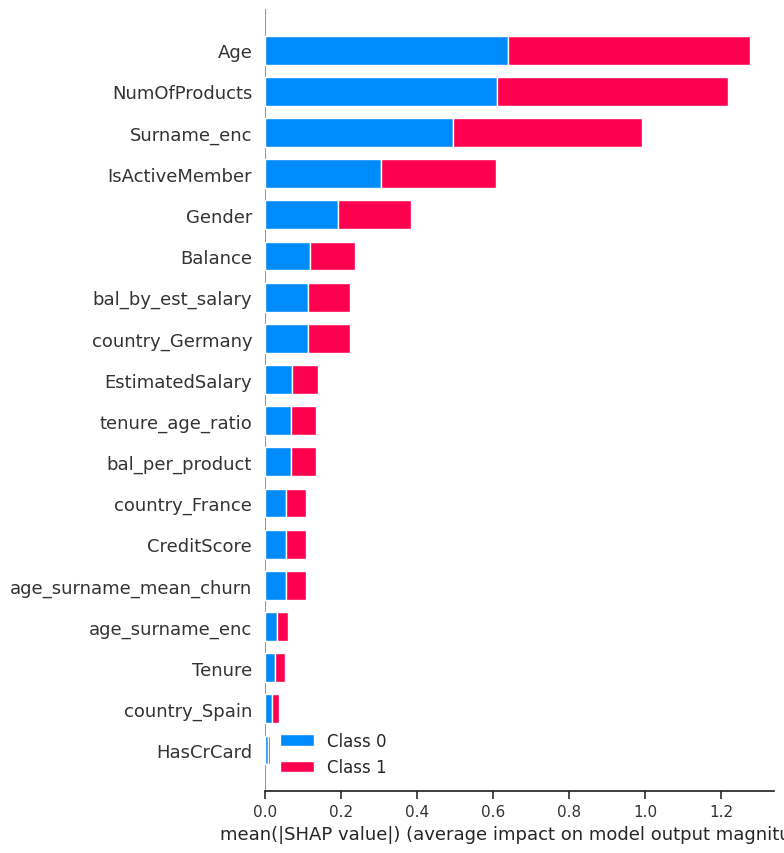

In [243]:
## Explain global patterns/ summary stats
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Load saved model and make predictions on unseen/future data

In [244]:
import joblib

## Load model object
model = joblib.load('final_churn_model_f1_0_45.sav')

X_test = df_test.drop(columns = ['Exited'], axis = 1)
X_test.shape
y_test.shape

(1000, 17)

(1000,)

<Axes: xlabel='Target', ylabel='Predicted_Prob'>

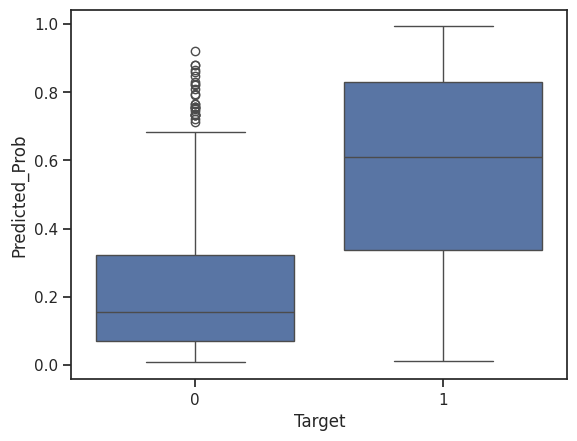

In [246]:
## Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]

## Predict target values on test data
test_preds = np.where(test_probs > 0.45, 1, 0) # Flexibility to tweak the probability threshold
#test_preds = model.predict(X_test)
# Create a DataFrame with target values and predicted probabilities
data_for_boxplot_test = pd.DataFrame({'Target': y_test.ravel(), 'Predicted_Prob': test_probs})

# Use boxplot with 'Target' as the x-axis variable and 'Predicted_Prob' as the y-axis variable
sns.boxplot(x='Target', y='Predicted_Prob', data=data_for_boxplot_test)

<Axes: xlabel='Target', ylabel='Predicted_Prob'>

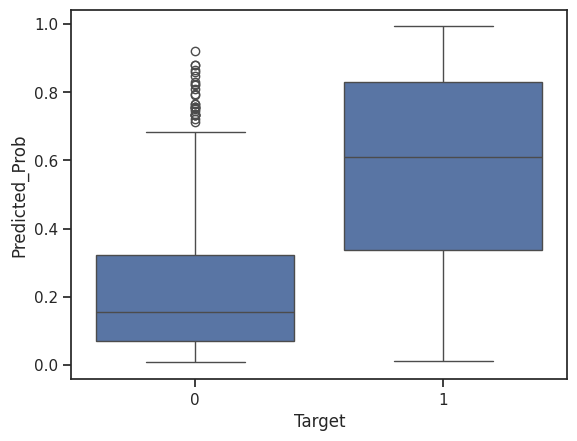

In [250]:
# Create a DataFrame with target values and predicted probabilities
data_for_boxplot_test = pd.DataFrame({'Target': y_test.ravel(), 'Predicted_Prob': test_probs})

# Use boxplot with 'Target' as the x-axis variable and 'Predicted_Prob' as the y-axis variable
sns.boxplot(x='Target', y='Predicted_Prob', data=data_for_boxplot_test)

In [251]:
## Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.7678570272911421

0.675392670157068

array([[696, 113],
       [ 62, 129]])

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       809
           1       0.53      0.68      0.60       191

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.84      0.82      0.83      1000



In [252]:
## Adding predictions and their probabilities in the original test dataframe
test = df_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs

test.sample(5)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
827          479       1   47       1       0.00              1          1   
92           773       0   50       4       0.00              2          1   
251          524       0   36      10       0.00              2          1   
400          601       1   50       2  115625.07              1          1   
353          823       1   38       1       0.00              2          1   

     IsActiveMember  EstimatedSalary  Exited  country_France  country_Germany  \
827               0         95270.83       0             1.0              0.0   
92                0        129372.94       0             1.0              0.0   
251               0        109614.57       0             1.0              0.0   
400               0        185855.21       0             1.0              0.0   
353               0        156603.70       0             1.0              0.0   

     country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
827            0.0     0.133333         0.000000           0.000000   
92             0.0     0.333333         0.000000           0.000000   
251            0.0     0.000000         0.000000           0.000000   
400            0.0     0.375000    115624.954375           0.622124   
353            0.0     0.203030         0.000000           0.000000   

     tenure_age_ratio  age_surname_mean_churn  predictions  pred_probabilities  
827          0.021277                0.914087            1            0.751175  
92           0.080000                2.357023            1            0.678181  
251          0.277778                0.000000            0            0.084563  
400          0.040000                2.651650            1            0.859918  
353          0.026316                1.251563            0            0.017334

Creating a list of customers who are the most likely to churn
---
Listing customers who have a churn probability higher than 70%. These are the ones who can be targeted immediately

In [253]:
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by = ['pred_probabilities'], ascending = False
                                                                 ).reset_index().drop(columns = ['index', 'Exited', 'predictions'], axis = 1)

high_churn_list.shape
high_churn_list.head()


(103, 18)

CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          546       0   58       3  106458.31              4          1   
1          479       1   51       1  107714.74              3          1   
2          745       1   45      10  117231.63              3          1   
3          515       1   45       7  120961.50              3          1   
4          481       0   57       9       0.00              3          1   

   IsActiveMember  EstimatedSalary  country_France  country_Germany  \
0               0        128881.87             0.0              1.0   
1               0         86128.21             0.0              1.0   
2               1        122381.02             0.0              1.0   
3               1         39288.11             0.0              1.0   
4               1        169719.35             1.0              0.0   

   country_Spain  Surname_enc  bal_per_product  bal_by_est_salary  \
0            0.0     0.000000     26614.570846           0.826015   
1            0.0     0.333333     35904.901365           1.250633   
2            0.0     0.250000     39077.196974           0.957923   
3            0.0     0.200000     40320.486560           3.078832   
4            0.0     0.222222         0.000000           0.000000   

   tenure_age_ratio  age_surname_mean_churn  pred_probabilities  
0          0.051724                0.000000            0.992935  
1          0.019608                2.380476            0.979605  
2          0.222222                1.677051            0.976361  
3          0.155556                1.341641            0.970001  
4          0.157895                1.677741            0.965838

In [254]:
high_churn_list.to_csv('high_churn_list.csv', index = False)

In [256]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [257]:
high_churn_list.to_csv('/content/drive/My Drive/high_churn_list.csv', index=False)